# **Scraping SatuSehat App Reviews**

# SET UP

In [1]:
# Install libraries
!pip install google_play_scraper
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 16.5 MB/s eta 0:00:00


In [4]:
# Import Libraries
# Standard libraries
import os
import time
import datetime
import re
from pathlib import Path
from PIL import Image

# Data handling and visualization libraries
import pandas as pd
import numpy as np
import regex as re
import nltk
import string
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as dates

# Machine learning and NLP libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from google_play_scraper import app, Sort, reviews, reviews_all
from copy import deepcopy
from IPython.display import clear_output
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Scraping App Reviews

* Nama aplikasi yang akan di-*scraping* *review*-nya pada Google Play adalah **SATUSEHAT Mobile**

*   Link App Android dari SatuSehat pada Google Play:
https://play.google.com/store/apps/details?id=com.telkom.tracencare&hl=id
*   ID aplikasi AloDokter adalah `id=com.telkom.tracencare`
* Pada tanggal 19 Oktober, jumlah review aplikasi pada Google Play adalah **1,11 jt**.


In [ ]:
# Mengambil review aplikasi Alodokter dari Google Play Store

# Fungsi untuk mengambil jumlah review berdasarkan yang diinginkan
def scrap_satusehat_reviews(
    app_id='com.telkom.tracencare',
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    total_reviews=350000,
    filter_score_with=None,
    filter_device_with=None
) -> list:
    # Mengambil batch pertama dari 100 review
    all_result, review_token = reviews(
        app_id,
        lang=lang,
        country=country,
        sort=sort,
        count=100,
        filter_score_with=filter_score_with,
        filter_device_with=filter_device_with,
        continuation_token=None  # Batch pertama, tanpa token kelanjutan
    )

    # Menghitung berapa kali kita perlu mengulang pengambilan data
    multiples = int(total_reviews / 100 - 1)
    print(f"Total reviews: {len(all_result)}/{total_reviews}")

    # Proses pengambilan batch selanjutnya hingga mencapai total_reviews yang diinginkan
    for i in range(multiples):
        result = []
        iterate_status = True
        token = deepcopy(review_token)  # Menyimpan token untuk batch berikutnya
        while iterate_status:
            result, review_token = reviews(app_id, continuation_token=token)
            if review_token.token:
                iterate_status = False
        for review in result:
            all_result.append(review)
        clear_output(wait=True)  # Membersihkan output untuk memantau progress
        print(f"Total reviews: {len(all_result)}/{total_reviews}")

    return all_result

# Mengambil 1.100.000 review
satusehat_reviews = scrap_satusehat_reviews(total_reviews=350000)

Total reviews: 350000/350000


In [ ]:
# Simpan review ke dalam DataFrame
df_satusehat = pd.DataFrame(np.array(satusehat_reviews), columns=['content'])
df_satusehat = df_satusehat.join(pd.DataFrame(df_satusehat.pop('content').tolist()))
df_satusehat.head()

reviewId           userName  \
0  7ac6eb4e-7dde-48fc-a19b-5c2bb8ce64de        Nahuda Alwi   
1  2b881d5e-11dd-4042-9dae-6b1c6d147c2e      ZAINAL ABIDIN   
2  d6b310b5-a9d9-4aeb-b624-ce3a8c34fcbe  Anggi Eka Permana   
3  a813dca8-8cc4-4de4-b2e4-c018c887a963       Rendi Ardian   
4  e11bbe1d-3374-48e6-b928-6bde1cda26e8     Erik Sebastian   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a/ACg8oc...   
1  https://play-lh.googleusercontent.com/a-/ALV-U...   
2  https://play-lh.googleusercontent.com/a/ACg8oc...   
3  https://play-lh.googleusercontent.com/a-/ALV-U...   
4  https://play-lh.googleusercontent.com/a/ACg8oc...   

                                        content  score  thumbsUpCount  \
0                      sy senang mengikuti pelď      4              0   
1                                         Bagus      5              0   
2                                         kacau      1              0   
3                     APLIKASI KOYOK GATHELLLL!      1              0   
4  Percuma di update malah tambah ga bisa login      1              0   

  reviewCreatedVersion                  at replyContent repliedAt appVersion  
0                 None 2024-10-18 05:30:39         None       NaT       None  
1                7.4.0 2024-10-18 00:29:34         None       NaT      7.4.0  
2                7.4.0 2024-10-18 00:12:59         None       NaT      7.4.0  
3                7.3.1 2024-10-17 17:12:28         None       NaT      7.3.1  
4                7.4.0 2024-10-17 11:10:26         None       NaT      7.4.0

In [ ]:
# Menampilkan jumlah baris dan kolom DataFrame
print(f"Jumlah data yang telah di-scraping: {df_satusehat.shape[0]}")

Jumlah data yang telah di-scraping: 350000


In [ ]:
# Simpan DataFrame ke dalam file CSV di direktori saat ini
file_path = 'df_satusehat_reviews.csv'

# Simpan DataFrame ke dalam file CSV dengan escapechar
df_satusehat.to_csv(file_path, index=False, escapechar='\\')

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_satusehat_reviews.csv


# Preprocessing Data

Sebelum menganalisis lebih lanjut, kita harus memahami tipe dan informasi lainnya terkait data yang telah kita miliki.

Dengan menggunakan fungsi `info`, dapat dilihat bahwa kolom "reviewCreatedVersion", "replyContent", "repliedAt", dan "appVersion" memiliki nilai null.

In [ ]:
# Informasi terkait data
df_satusehat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350000 entries, 0 to 349999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              350000 non-null  object        
 1   userName              350000 non-null  object        
 2   userImage             350000 non-null  object        
 3   content               350000 non-null  object        
 4   score                 350000 non-null  int64         
 5   thumbsUpCount         350000 non-null  int64         
 6   reviewCreatedVersion  291709 non-null  object        
 7   at                    350000 non-null  datetime64[ns]
 8   replyContent          224372 non-null  object        
 9   repliedAt             224372 non-null  datetime64[ns]
 10  appVersion            291709 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 29.4+ MB


Selanjutnya kita ingin melihat semua nilai unik dalam kolom 'reviewCreatedVersion' untuk mengetahui versi apa saja yang tersedia pada review app SatuSehat yang telah kita ambil.

In [ ]:
unique_versions = df_satusehat.reviewCreatedVersion.unique()
print("Versi Aplikasi yang Unik dalam Review:")
print(unique_versions)

num_unique_versions = df_satusehat.reviewCreatedVersion.nunique()
print(f"\nJumlah versi aplikasi dalam review yang diambil adalah: {num_unique_versions}")

Versi Aplikasi yang Unik dalam Review:
[None '7.4.0' '7.3.1' '4.0.7' '4.5.2' '6.2.2' '7.1.0' '6.2.0' '7.2.1'
 '5.5.2' '4.0.2' '4.1.0' '5.12.1' '6.5.0' '7.0.1' '6.4.0' '7.1.2' '7.2.2'
 '4.0.6' '3.0.2' '5.14.1' '5.7.1' '6.2.1' '4.6.0' '5.4.4' '4.4.4' '6.3.0'
 '3.4.6' '5.12.0' '4.5.6' '5.13.1' '5.10.2' '5.2.1' '5.13.0' '7.1.1'
 '4.4.8' '6.1.0' '7.2.0' '4.4.3.1' '4.0.9' '4.5.0' '4.4.3.2' '5.14.0'
 '4.5.9.1' '5.2.0' '6.0.1' '7.0.0' '4.1.16' '5.3.1' '5.8.0' '4.4.7'
 '4.4.1' '5.9.1' '3.4.1' '4.5.9' '4.2.0' '4.4.6' '5.9.0' '4.5.8' '5.7.0'
 '4.5.4' '4.1.1' '4.0.8' '5.10.0' '4.4.5' '4.5.3' '5.8.1' '5.11.0'
 '5.11.1' '3.4.5' '4.0.91' '4.5.1' '4.2.1' '4.0.5' '4.5.3.1' '1.2.0'
 '5.6.0' '5.10.1' '4.5.5' '4.5.7' '5.0.0' '4.3.0' '5.3.2' '3.3.5' '3.4.4'
 '5.5.0' '4.4' '3.4.0' '4.4.3' '5.5.1' '2.1.4' '3.3.6' '3.4.3' '3.2.6'
 '3.4.2' '2.2.2' '3.3.4' '2.3.0' '3.1.1' '2.0.0' '1.3.1' '1.0.1' '2.0.3'
 '1.4.0' '3.1.3' '2.0.2' '2.1.3' '2.2.1' '3.1.2' '1.0' '1.3.0']

Jumlah versi aplikasi dalam review yang diam

## Menghapus Emoji

Dapat dilihat pada DataFrame di atas bahwa kolom "content" ada yang berisi emoji saja. Oleh karena itu, kita akan menghapus emoji yang terdapat pada kolom "content"

In [8]:
# Fungsi untuk menghapus emoji dan karakter khusus dari teks
# Source: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emojis(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

# Menghapus emoji dan simbol dari kolom 'content'
df_satusehat['content'] = df_satusehat['content'].apply(remove_emojis)

In [ ]:
df_satusehat

reviewId           userName  \
0       7ac6eb4e-7dde-48fc-a19b-5c2bb8ce64de        Nahuda Alwi   
1       2b881d5e-11dd-4042-9dae-6b1c6d147c2e      ZAINAL ABIDIN   
2       d6b310b5-a9d9-4aeb-b624-ce3a8c34fcbe  Anggi Eka Permana   
3       a813dca8-8cc4-4de4-b2e4-c018c887a963       Rendi Ardian   
4       e11bbe1d-3374-48e6-b928-6bde1cda26e8     Erik Sebastian   
...                                      ...                ...   
349995  f12958b1-8073-492f-80f7-5884d860b432          Agus Suga   
349996  5ef7472f-e390-4c7d-b69f-060845fb853f         Deden Jhon   
349997  b799507e-1b10-40f6-ada9-446057dbaeae      Mahmud Faisal   
349998  33ed3cde-34dc-424a-b15f-c237e090e89c           Herwindo   
349999  7880d555-350e-4260-8b3b-485b45f8cb29     Suryanto Yanto   

                                                userImage  \
0       https://play-lh.googleusercontent.com/a/ACg8oc...   
1       https://play-lh.googleusercontent.com/a-/ALV-U...   
2       https://play-lh.googleusercontent.com/a/ACg8oc...   
3       https://play-lh.googleusercontent.com/a-/ALV-U...   
4       https://play-lh.googleusercontent.com/a/ACg8oc...   
...                                                   ...   
349995  https://play-lh.googleusercontent.com/a-/ALV-U...   
349996  https://play-lh.googleusercontent.com/a-/ALV-U...   
349997  https://play-lh.googleusercontent.com/a/ACg8oc...   
349998  https://play-lh.googleusercontent.com/a/ACg8oc...   
349999  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                                  content  score  \
0                                sy senang mengikuti pelď      4   
1                                                   Bagus      5   
2                                                   kacau      1   
3                               APLIKASI KOYOK GATHELLLL!      1   
4            Percuma di update malah tambah ga bisa login      1   
...                                                   ...    ...   
349995   Sangat mudah untuk mengecek sertifikat vaksinnya      5   
349996                                              Bagus      5   
349997  Tidak bisa masuk gagal mendaftar Jangan asal2a...      1   
349998                                        Sangat baik      5   
349999                                    Sangat m mbantu      5   

        thumbsUpCount reviewCreatedVersion                  at  \
0                   0                 None 2024-10-18 05:30:39   
1                   0                7.4.0 2024-10-18 00:29:34   
2                   0                7.4.0 2024-10-18 00:12:59   
3                   0                7.3.1 2024-10-17 17:12:28   
4                   0                7.4.0 2024-10-17 11:10:26   
...               ...                  ...                 ...   
349995              0                3.4.0 2021-07-26 00:39:09   
349996              0                3.3.6 2021-07-26 00:38:53   
349997              0                3.4.0 2021-07-26 00:38:19   
349998              0                3.3.6 2021-07-26 00:37:56   
349999              0                3.3.6 2021-07-26 00:37:09   

                                             replyContent           repliedAt  \
0                                                    None                 NaT   
1                                                    None                 NaT   
2                                                    None                 NaT   
3                                                    None                 NaT   
4                                                    None                 NaT   
...                                                   ...                 ...   
349995  Halo Agus Suga,\n\nTerima kasih atas dukungan ... 2021-08-27 02:35:07   
349996  Halo Deden Jhon,\n\nTerima kasih atas dukungan... 2021-08-27 02:36:02   
349997  Halo Mahmud Faisal,\n\nKami mohon maaf atas ke... 2021-08-27 02:37:06   
349998  Halo Herwindo,\nTerima kasih atas dukungan And... 2021-08-27 01:21:30 

## Menghapus Review yang Kosong

Menghapus emoji dan karakter spesial memungkinkan beberapa review menjadi kosong, sehingga kita harus mengecek dan menghapusnya bila ada.

In [ ]:
# Menghapus review yang bernilai kosong
df_satusehat = df_satusehat[df_satusehat['content'] != '']

In [ ]:
# Memeriksa apakah masih ada review kosong pada kolom 'content' atau tidak
df_satusehat[df_satusehat['content'] == '']

Empty DataFrame
Columns: [reviewId, userName, userImage, content, score, thumbsUpCount, reviewCreatedVersion, at, replyContent, repliedAt, appVersion]
Index: []

In [ ]:
# Jumlah data setelah melakukan preprocessing
df_satusehat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344936 entries, 0 to 349999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   reviewId              344936 non-null  object        
 1   userName              344936 non-null  object        
 2   userImage             344936 non-null  object        
 3   content               344936 non-null  object        
 4   score                 344936 non-null  int64         
 5   thumbsUpCount         344936 non-null  int64         
 6   reviewCreatedVersion  287469 non-null  object        
 7   at                    344936 non-null  datetime64[ns]
 8   replyContent          221108 non-null  object        
 9   repliedAt             221108 non-null  datetime64[ns]
 10  appVersion            287469 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 31.6+ MB


Jumlah data yang awalnya berjumlah 350.000 kini menjadi 344.936

## Lowercasing Reviews

Membuat seluruh teks pada kolom 'content' menjadi huruf kecil menjadi hal yang penting agar teks menjadi konsisten dan homogen. Hal ini juga bertujuan untuk meningkatkan akurasi dari setiap teks.

In [ ]:
# Mengubah tipe data kolom content menjadi string
df_satusehat.loc[:, 'content'] = df_satusehat['content'].astype(str)

In [ ]:
# Mengubah semua teks di kolom 'content' menjadi huruf kecil
df_satusehat.loc[:, 'content'] = df_satusehat['content'].apply(lambda x: x.lower())

In [ ]:
df_satusehat

reviewId           userName  \
0       7ac6eb4e-7dde-48fc-a19b-5c2bb8ce64de        Nahuda Alwi   
1       2b881d5e-11dd-4042-9dae-6b1c6d147c2e      ZAINAL ABIDIN   
2       d6b310b5-a9d9-4aeb-b624-ce3a8c34fcbe  Anggi Eka Permana   
3       a813dca8-8cc4-4de4-b2e4-c018c887a963       Rendi Ardian   
4       e11bbe1d-3374-48e6-b928-6bde1cda26e8     Erik Sebastian   
...                                      ...                ...   
349995  f12958b1-8073-492f-80f7-5884d860b432          Agus Suga   
349996  5ef7472f-e390-4c7d-b69f-060845fb853f         Deden Jhon   
349997  b799507e-1b10-40f6-ada9-446057dbaeae      Mahmud Faisal   
349998  33ed3cde-34dc-424a-b15f-c237e090e89c           Herwindo   
349999  7880d555-350e-4260-8b3b-485b45f8cb29     Suryanto Yanto   

                                                userImage  \
0       https://play-lh.googleusercontent.com/a/ACg8oc...   
1       https://play-lh.googleusercontent.com/a-/ALV-U...   
2       https://play-lh.googleusercontent.com/a/ACg8oc...   
3       https://play-lh.googleusercontent.com/a-/ALV-U...   
4       https://play-lh.googleusercontent.com/a/ACg8oc...   
...                                                   ...   
349995  https://play-lh.googleusercontent.com/a-/ALV-U...   
349996  https://play-lh.googleusercontent.com/a-/ALV-U...   
349997  https://play-lh.googleusercontent.com/a/ACg8oc...   
349998  https://play-lh.googleusercontent.com/a/ACg8oc...   
349999  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                                  content  score  \
0                                sy senang mengikuti pelď      4   
1                                                   bagus      5   
2                                                   kacau      1   
3                               aplikasi koyok gathellll!      1   
4            percuma di update malah tambah ga bisa login      1   
...                                                   ...    ...   
349995   sangat mudah untuk mengecek sertifikat vaksinnya      5   
349996                                              bagus      5   
349997  tidak bisa masuk gagal mendaftar jangan asal2a...      1   
349998                                        sangat baik      5   
349999                                    sangat m mbantu      5   

        thumbsUpCount reviewCreatedVersion                  at  \
0                   0                 None 2024-10-18 05:30:39   
1                   0                7.4.0 2024-10-18 00:29:34   
2                   0                7.4.0 2024-10-18 00:12:59   
3                   0                7.3.1 2024-10-17 17:12:28   
4                   0                7.4.0 2024-10-17 11:10:26   
...               ...                  ...                 ...   
349995              0                3.4.0 2021-07-26 00:39:09   
349996              0                3.3.6 2021-07-26 00:38:53   
349997              0                3.4.0 2021-07-26 00:38:19   
349998              0                3.3.6 2021-07-26 00:37:56   
349999              0                3.3.6 2021-07-26 00:37:09   

                                             replyContent           repliedAt  \
0                                                    None                 NaT   
1                                                    None                 NaT   
2                                                    None                 NaT   
3                                                    None                 NaT   
4                                                    None                 NaT   
...                                                   ...                 ...   
349995  Halo Agus Suga,\n\nTerima kasih atas dukungan ... 2021-08-27 02:35:07   
349996  Halo Deden Jhon,\n\nTerima kasih atas dukungan... 2021-08-27 02:36:02   
349997  Halo Mahmud Faisal,\n\nKami mohon maaf atas ke... 2021-08-27 02:37:06   
349998  Halo Herwindo,\nTerima kasih atas dukungan And... 2021-08-27 01:21:30 

## Seleksi Kolom yang Digunakan

Dari 11 kolom yang ada, tidak semua kolom akan digunakan untuk analisis sentimen. Pada tahap ini kolom akan dipilih berdasarkan yang paling relevan saja.

In [ ]:
df_satusehat.loc[0:3,["content", "score", "thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


content  score  thumbsUpCount reviewCreatedVersion  \
0   sy senang mengikuti pelď      4              0                 None   
1                      bagus      5              0                7.4.0   
2                      kacau      1              0                7.4.0   
3  aplikasi koyok gathellll!      1              0                7.3.1   

                   at replyContent repliedAt  
0 2024-10-18 05:30:39         None       NaT  
1 2024-10-18 00:29:34         None       NaT  
2 2024-10-18 00:12:59         None       NaT  
3 2024-10-17 17:12:28         None       NaT

In [ ]:
# Membuat df baru untuk analisis sentimen TextBlob
df_satusehat_sentiment1 = df_satusehat.copy()

# Sentiment Analysis

## Sentiment Analysis menggunakan TextBlob

### Sentiment Polarity & Subjectivity

Pada tahap ini, kita akan menghitung nilai *sentiment polarity* dan *sentiment subjective* pada kolom 'content' menggunakan `TextBlob`.
Lebih lengkap dapat dilihat pada: https://textblob.readthedocs.io/en/dev/quickstart.html

In [ ]:
!pip install textblob

In [ ]:
from textblob import TextBlob

# Menghitung polaritas dan subjektivitas sentimen
df_satusehat_sentiment1.loc[:, 'sentiment_polarity'] = df_satusehat_sentiment1['content'].apply(lambda x: TextBlob(x).polarity)
df_satusehat_sentiment1.loc[:, 'sentiment_subjective'] = df_satusehat_sentiment1['content'].apply(lambda x: TextBlob(x).subjectivity)

In [ ]:
df_satusehat_sentiment1.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

content  score  \
0                                sy senang mengikuti pelď      4   
1                                                   bagus      5   
2                                                   kacau      1   
3                               aplikasi koyok gathellll!      1   
4            percuma di update malah tambah ga bisa login      1   
...                                                   ...    ...   
349995   sangat mudah untuk mengecek sertifikat vaksinnya      5   
349996                                              bagus      5   
349997  tidak bisa masuk gagal mendaftar jangan asal2a...      1   
349998                                        sangat baik      5   
349999                                    sangat m mbantu      5   

        sentiment_polarity  sentiment_subjective  
0                      0.0                   0.0  
1                      0.0                   0.0  
2                      0.0                   0.0  
3                      0.0                   0.0  
4                      0.0                   0.0  
...                    ...                   ...  
349995                 0.0                   0.0  
349996                 0.0                   0.0  
349997                 0.0                   0.0  
349998                 0.0                   0.0  
349999                 0.0                   0.0  

[344936 rows x 4 columns]

In [ ]:
# Mengecek jumlah data setiap rating (kolom "score")
df_satusehat_sentiment1['score'].value_counts()

score
5    150517
1    130158
4     22610
2     21086
3     20565
Name: count, dtype: int64

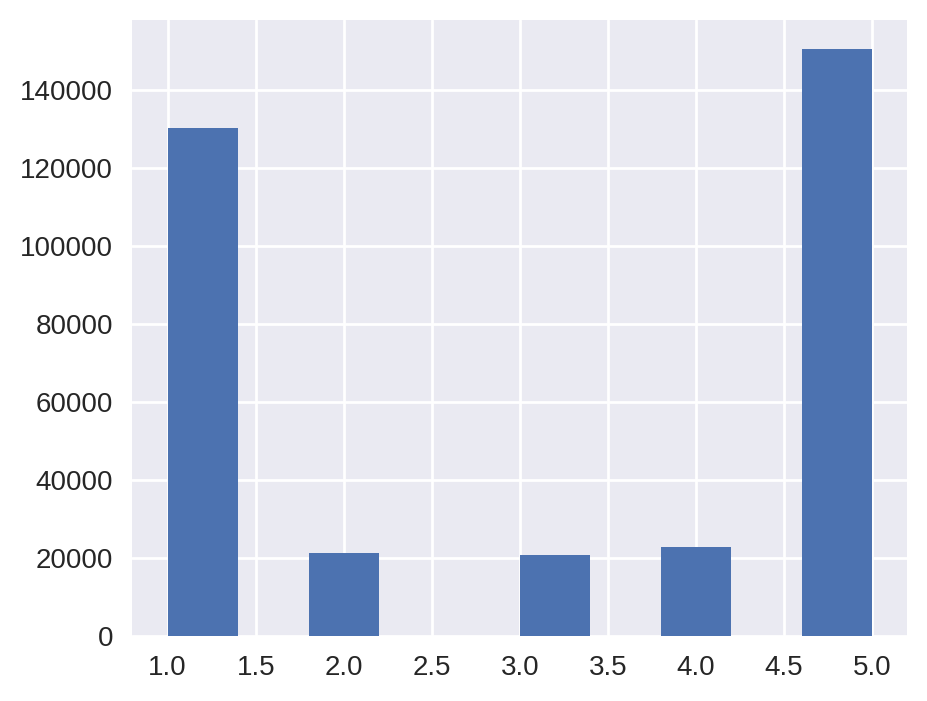

In [ ]:
# Menampilkan review score ke dalam bar chart
plt.figure(figsize=[5,4])
plt.hist(df_satusehat_sentiment1['score'])
plt.show()

### Sentiment Rating

Setelah mengetahui jumlah rating dari setiap pengguna pada review aplikasi SatuSehat di Google Play, kita dapat mengategorikan review ke dalam sentiment rating dimana **Positive** (rating 4/5), **Netral** (rating 3), **Negative** (rating 1/2).

In [ ]:
# Menambah kolom sentiment_rating
df_satusehat_sentiment1.loc[:, 'sentiment_rating'] = df_satusehat_sentiment1['score'].apply(lambda x: 'Positive' if x > 3 else ('Neutral' if x == 3 else 'Negative'))

In [ ]:
df_satusehat_sentiment1.loc[:,["content", "score", "sentiment_polarity", "sentiment_subjective", "sentiment_rating"]]

content  score  \
0                                sy senang mengikuti pelď      4   
1                                                   bagus      5   
2                                                   kacau      1   
3                               aplikasi koyok gathellll!      1   
4            percuma di update malah tambah ga bisa login      1   
...                                                   ...    ...   
349995   sangat mudah untuk mengecek sertifikat vaksinnya      5   
349996                                              bagus      5   
349997  tidak bisa masuk gagal mendaftar jangan asal2a...      1   
349998                                        sangat baik      5   
349999                                    sangat m mbantu      5   

        sentiment_polarity  sentiment_subjective sentiment_rating  
0                      0.0                   0.0         Positive  
1                      0.0                   0.0         Positive  
2                      0.0                   0.0         Negative  
3                      0.0                   0.0         Negative  
4                      0.0                   0.0         Negative  
...                    ...                   ...              ...  
349995                 0.0                   0.0         Positive  
349996                 0.0                   0.0         Positive  
349997                 0.0                   0.0         Negative  
349998                 0.0                   0.0         Positive  
349999                 0.0                   0.0         Positive  

[344936 rows x 5 columns]

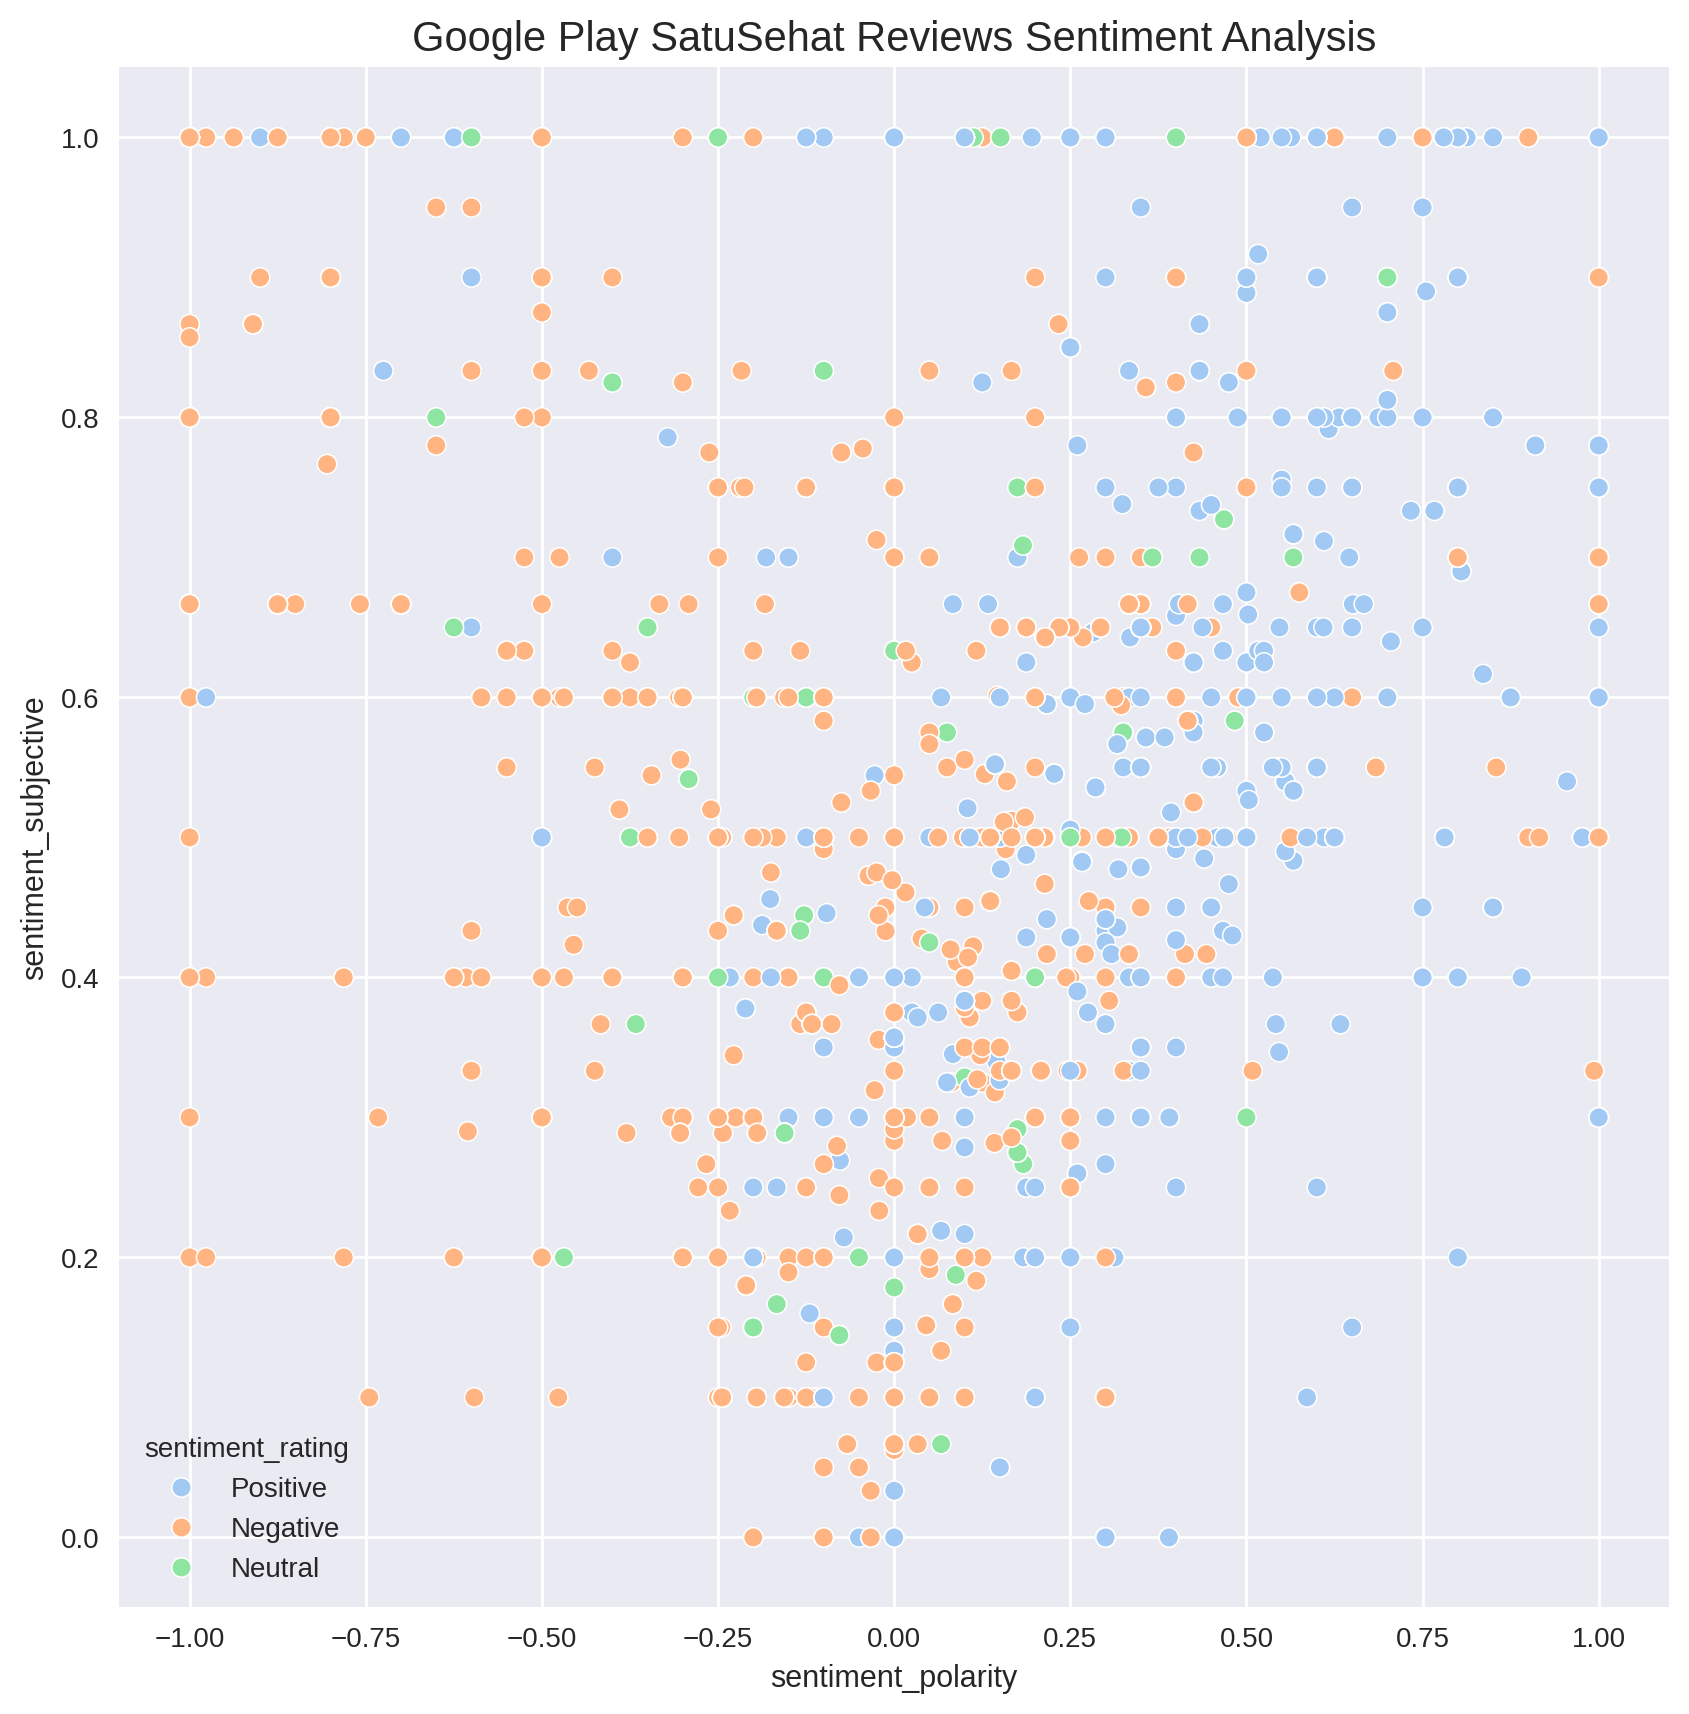

In [ ]:
# Membandingkan sentiment rating dengan nilai polarity dan subjective (TextBlob)
plt.figure(figsize=(10, 10))
sns.scatterplot(df_satusehat_sentiment1, x='sentiment_polarity', y='sentiment_subjective',
                hue='sentiment_rating', edgecolor='white', palette="pastel")
plt.title("Google Play SatuSehat Reviews Sentiment Analysis", fontsize=15)
plt.show()



Kesimpulan hasil visualisasi di atas:


1.   **Penyebaran Sentimen Polarity dan Subjectivity**
- Nilai sentiment_polarity berkisar dari -1.0 hingga 1.0, menunjukkan bahwa data mencakup rentang lengkap dari sentimen negatif (di bawah 0), positif (di atas 0), dan netral (sekitar 0).
- Nilai sentiment_subjective berkisar antara 0.0 hingga 1.0, di mana nilai 1.0 menunjukkan subjektivitas yang tinggi dan 0.0 menunjukkan objektivitas yang tinggi.


2.  **Distribusi Kategori Sentimen**
- Data dengan polarity 0.0 (sentimen netral) dan subjectivity 0.0 cenderung sedikit namun tetap ada, yang mengindikasikan adanya kalimat yang secara polaritas netral dan lebih objektif.
- Warna oranye (sentimen negatif) tersebar cukup merata di seluruh area polarity negatif dan menunjukkan subyektivitas yang beragam.
- Warna biru (sentimen positif) umumnya terkonsentrasi di wilayah polarity positif dengan subyektivitas tinggi.
- Warna hijau (sentimen netral) tersebar terutama di sekitar 0 untuk polarity, tetapi memiliki nilai subyektivitas yang bervariasi.

3. **Keberadaan Anomali (outliers)**
- Ada beberapa poin yang sangat mendekati polarity 0.0 namun dengan nilai subjectivity bervariasi, mengindikasikan bahwa terdapat kalimat yang secara polaritas netral tetapi dinilai sangat subjektif atau objektif.
- Library yang digunakan adalah `TextBlob`, sehingga akan kurang akurat untuk data yang tidak berbahasa Inggris.


4. **Skalabilitas Data**
- Dengan data berjumlah 344k+, sebaran yang tampak relatif acak ini menunjukkan bahwa sebagian besar data berada di sekitar sentimen negatif dan netral dengan subyektivitas yang bervariasi. Ini bisa menunjukkan bahwa analisis sentimen untuk data Bahasa Indonesia yang digunakan lebih cenderung memberikan nilai negatif atau netral daripada positif.

# Sentiment Analysis 150k Reviews
Dikarenakan keterbatasan komputasi, maka data yang digunakan hanyalah 150k. Meskipun begitu, data ini sudah mencakup versi aplikasi selama masih menjadi 'PeduliLindungi' dan setelah diperbarui menjadi 'SatuSehat'.

In [3]:
# Mengambil review aplikasi Alodokter dari Google Play Store

# Fungsi untuk mengambil jumlah review berdasarkan yang diinginkan
def scrap_satusehat_reviews(
    app_id='com.telkom.tracencare',
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    total_reviews=1500000,
    filter_score_with=None,
    filter_device_with=None
) -> list:
    # Mengambil batch pertama dari 100 review
    all_result, review_token = reviews(
        app_id,
        lang=lang,
        country=country,
        sort=sort,
        count=100,
        filter_score_with=filter_score_with,
        filter_device_with=filter_device_with,
        continuation_token=None  # Batch pertama, tanpa token kelanjutan
    )

    # Menghitung berapa kali kita perlu mengulang pengambilan data
    multiples = int(total_reviews / 100 - 1)
    print(f"Total reviews: {len(all_result)}/{total_reviews}")

    # Proses pengambilan batch selanjutnya hingga mencapai total_reviews yang diinginkan
    for i in range(multiples):
        result = []
        iterate_status = True
        token = deepcopy(review_token)  # Menyimpan token untuk batch berikutnya
        while iterate_status:
            result, review_token = reviews(app_id, continuation_token=token)
            if review_token.token:
                iterate_status = False
        for review in result:
            all_result.append(review)
        clear_output(wait=True)  # Membersihkan output untuk memantau progress
        print(f"Total reviews: {len(all_result)}/{total_reviews}")

    return all_result

# Mengambil 150.000 review
satusehat_reviews = scrap_satusehat_reviews(total_reviews=150000)

Total reviews: 150000/150000


In [5]:
# Simpan review ke dalam DataFrame
df_satusehat = pd.DataFrame(np.array(satusehat_reviews), columns=['content'])
df_satusehat = df_satusehat.join(pd.DataFrame(df_satusehat.pop('content').tolist()))
df_satusehat.head()

reviewId             userName  \
0  661e8d1c-4776-4bd9-8926-92ff986016b4    Della Nur Safirah   
1  e58b361b-170d-48e9-aee5-374ff3c08ae7         Fadila Fahmi   
2  bd7d78e6-9081-418f-89b3-29e75bf1fc54  Kartika Anisa Putri   
3  f869c729-2165-4423-a65d-4aa24bb08837           udin Media   
4  9fe127a4-1430-421b-8a73-820116ba81dd         Ahmad Nawawi   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a-/ALV-U...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a/ACg8oc...   
4  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                             content  score  thumbsUpCount  \
0                         kalo gk niat gausah, jelek      1              0   
1  Saya gak pernah gunakan tiba no saya ada dafta...      1              0   
2  Dulu saat masih PeduliLindungi saya sempat daf...      1              0   
3                                    Membantu sekali      5              0   
4                    Kenapa akun saya ga bisa log in      1              0   

  reviewCreatedVersion                  at  \
0                 None 2024-11-25 13:04:29   
1                7.6.0 2024-11-25 10:29:16   
2                 None 2024-11-25 06:14:21   
3                7.6.0 2024-11-25 04:18:30   
4                7.6.0 2024-11-24 11:45:51   

                                        replyContent           repliedAt  \
0  Halo Healthies,\nTerima kasih telah meluangkan... 2024-11-25 13:08:16   
1  Halo Healthies,\nTerima kasih telah meluangkan... 2024-11-25 10:32:59   
2  Halo Healthies,\nTerima kasih telah meluangkan... 2024-11-25 06:16:24   
3  Halo Healthies,\nTerima kasih atas ulasan posi... 2024-11-25 04:23:35   
4  Halo Healthies,\nTerima kasih telah meluangkan... 2024-11-24 11:49:45   

  appVersion  
0       None  
1      7.6.0  
2       None  
3      7.6.0  
4      7.6.0

In [6]:
# Menampilkan jumlah baris dan kolom DataFrame
print(f"Jumlah data yang telah di-scraping: {df_satusehat.shape[0]}")

Jumlah data yang telah di-scraping: 150000


In [7]:
# Simpan DataFrame ke dalam file CSV di direktori saat ini
file_path = 'df_satusehat_150k_reviews.csv'

# Simpan DataFrame ke dalam file CSV dengan escapechar
df_satusehat.to_csv(file_path, index=False, escapechar='\\')

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_satusehat_150k_reviews.csv


### Preprocessing Kembali untuk 150k
langkah yang digunakan sama dengan yang sebelumnya

In [9]:
df_satusehat['content'] = df_satusehat['content'].apply(remove_emojis)

In [10]:
df_satusehat = df_satusehat[df_satusehat['content'] != '']

In [11]:
df_satusehat.loc[:, 'content'] = df_satusehat['content'].astype(str)
df_satusehat.loc[:, 'content'] = df_satusehat['content'].apply(lambda x: x.lower())

In [12]:
df_satusehat

reviewId             userName  \
0       661e8d1c-4776-4bd9-8926-92ff986016b4    Della Nur Safirah   
1       e58b361b-170d-48e9-aee5-374ff3c08ae7         Fadila Fahmi   
2       bd7d78e6-9081-418f-89b3-29e75bf1fc54  Kartika Anisa Putri   
3       f869c729-2165-4423-a65d-4aa24bb08837           udin Media   
4       9fe127a4-1430-421b-8a73-820116ba81dd         Ahmad Nawawi   
...                                      ...                  ...   
149995  72f0003d-cf71-4a14-a846-da94ca3afaf9        Oppo Foneflus   
149996  df40e7bb-fe0b-48c1-8a4c-c6d6549a1758       Rinda Mindarko   
149997  ae0d52b7-60a1-4110-946c-fbbf7d1ea791        Sulaeman Apip   
149998  c7f15b90-8bc7-434d-944c-3a08808dae5e             silas 07   
149999  85c32b26-87a0-498e-85b9-a15160fbe116    Rezaharmonis Reza   

                                                userImage  \
0       https://play-lh.googleusercontent.com/a-/ALV-U...   
1       https://play-lh.googleusercontent.com/a-/ALV-U...   
2       https://play-lh.googleusercontent.com/a-/ALV-U...   
3       https://play-lh.googleusercontent.com/a/ACg8oc...   
4       https://play-lh.googleusercontent.com/a-/ALV-U...   
...                                                   ...   
149995  https://play-lh.googleusercontent.com/a/ACg8oc...   
149996  https://play-lh.googleusercontent.com/a/ACg8oc...   
149997  https://play-lh.googleusercontent.com/a-/ALV-U...   
149998  https://play-lh.googleusercontent.com/a/ACg8oc...   
149999  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                                  content  score  \
0                              kalo gk niat gausah, jelek      1   
1       saya gak pernah gunakan tiba no saya ada dafta...      1   
2       dulu saat masih pedulilindungi saya sempat daf...      1   
3                                         membantu sekali      5   
4                         kenapa akun saya ga bisa log in      1   
...                                                   ...    ...   
149995                                    sangat membantu      5   
149996                                           mk...ķ x      4   
149997  gak bisa verfikasi..padahal data data saya sud...      1   
149998                                                gbu      5   
149999                                              bagus      4   

        thumbsUpCount reviewCreatedVersion                  at  \
0                   0                 None 2024-11-25 13:04:29   
1                   0                7.6.0 2024-11-25 10:29:16   
2                   0                 None 2024-11-25 06:14:21   
3                   0                7.6.0 2024-11-25 04:18:30   
4                   0                7.6.0 2024-11-24 11:45:51   
...               ...                  ...                 ...   
149995              0                4.0.2 2021-12-11 04:51:31   
149996              0                 None 2021-12-11 04:47:51   
149997              0                4.0.5 2021-12-11 04:47:27   
149998              0                4.0.5 2021-12-11 04:46:35   
149999              0                4.0.5 2021-12-11 04:45:03   

                                             replyContent           repliedAt  \
0       Halo Healthies,\nTerima kasih telah meluangkan... 2024-11-25 13:08:16   
1       Halo Healthies,\nTerima kasih telah meluangkan... 2024-11-25 10:32:59   
2       Halo Healthies,\nTerima kasih telah meluangkan... 2024-11-25 06:16:24   
3       Halo Healthies,\nTerima kasih atas ulasan posi... 2024-11-25 04:23:35   
4       Halo Healthies,\nTerima kasih telah meluangkan... 2024-11-24 11:49:45   
...                                                   ...                 ...   
149995  Halo Kak,\n\nTerima kasih atas dukungan Anda.\... 2021-12-11 10:45:00   
149996  Halo Kak,\n\nTerima kasih atas dukungan Anda.\... 2021-12-11 10:45:13   
149997  Halo,\nMohon maaf atas ketidaknyamanan Anda.\n... 2021-12-11 10:45:32   
149998  Halo Kak,\n\nTerima kasih atas dukungan Anda.\

### Sentiment Rating

In [23]:
# Menambah kolom sentiment_rating
df_satusehat.loc[:, 'sentiment_rating'] = df_satusehat['score'].apply(lambda x: 'Positive' if x > 3 else ('Neutral' if x == 3 else 'Negative'))

In [24]:
df_satusehat.loc[:,["content", "score", "sentiment_rating"]]

content  score  \
0                              kalo gk niat gausah, jelek      1   
1       saya gak pernah gunakan tiba no saya ada dafta...      1   
2       dulu saat masih pedulilindungi saya sempat daf...      1   
3                                         membantu sekali      5   
4                         kenapa akun saya ga bisa log in      1   
...                                                   ...    ...   
149995                                    sangat membantu      5   
149996                                           mk...ķ x      4   
149997  gak bisa verfikasi..padahal data data saya sud...      1   
149998                                                gbu      5   
149999                                              bagus      4   

       sentiment_rating  
0              Negative  
1              Negative  
2              Negative  
3              Positive  
4              Negative  
...                 ...  
149995         Positive  
149996         Positive  
149997         Negative  
149998         Positive  
149999         Positive  

[147595 rows x 3 columns]

# Text Analysis (Sebelum Stopwords)

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [16]:
# Menghitung jumlah kata dengan tokenisasi menggunakan NLTK
df_satusehat['wordCount'] = df_satusehat['content'].apply(lambda x: len(word_tokenize(x)))
df_satusehat['uppercaseCharCount'] = [sum(char.isupper() for char in review) for review in df_satusehat['content']]
df_satusehat['specialCharCount'] = [sum(char in string.punctuation for char in review) for review in df_satusehat['content']]

In [17]:
df_satusehat.loc[:,["content","score","wordCount","uppercaseCharCount","specialCharCount"]]

content  score  wordCount  \
0                              kalo gk niat gausah, jelek      1          6   
1       saya gak pernah gunakan tiba no saya ada dafta...      1         12   
2       dulu saat masih pedulilindungi saya sempat daf...      1         86   
3                                         membantu sekali      5          2   
4                         kenapa akun saya ga bisa log in      1          7   
...                                                   ...    ...        ...   
149995                                    sangat membantu      5          2   
149996                                           mk...ķ x      4          4   
149997  gak bisa verfikasi..padahal data data saya sud...      1         14   
149998                                                gbu      5          1   
149999                                              bagus      4          1   

        uppercaseCharCount  specialCharCount  
0                        0                 1  
1                        0                 0  
2                        0                15  
3                        0                 0  
4                        0                 0  
...                    ...               ...  
149995                   0                 0  
149996                   0                 3  
149997                   0                 6  
149998                   0                 0  
149999                   0                 0  

[147595 rows x 5 columns]

In [18]:
# Fungsi untuk menghitung kata yang sering muncul
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

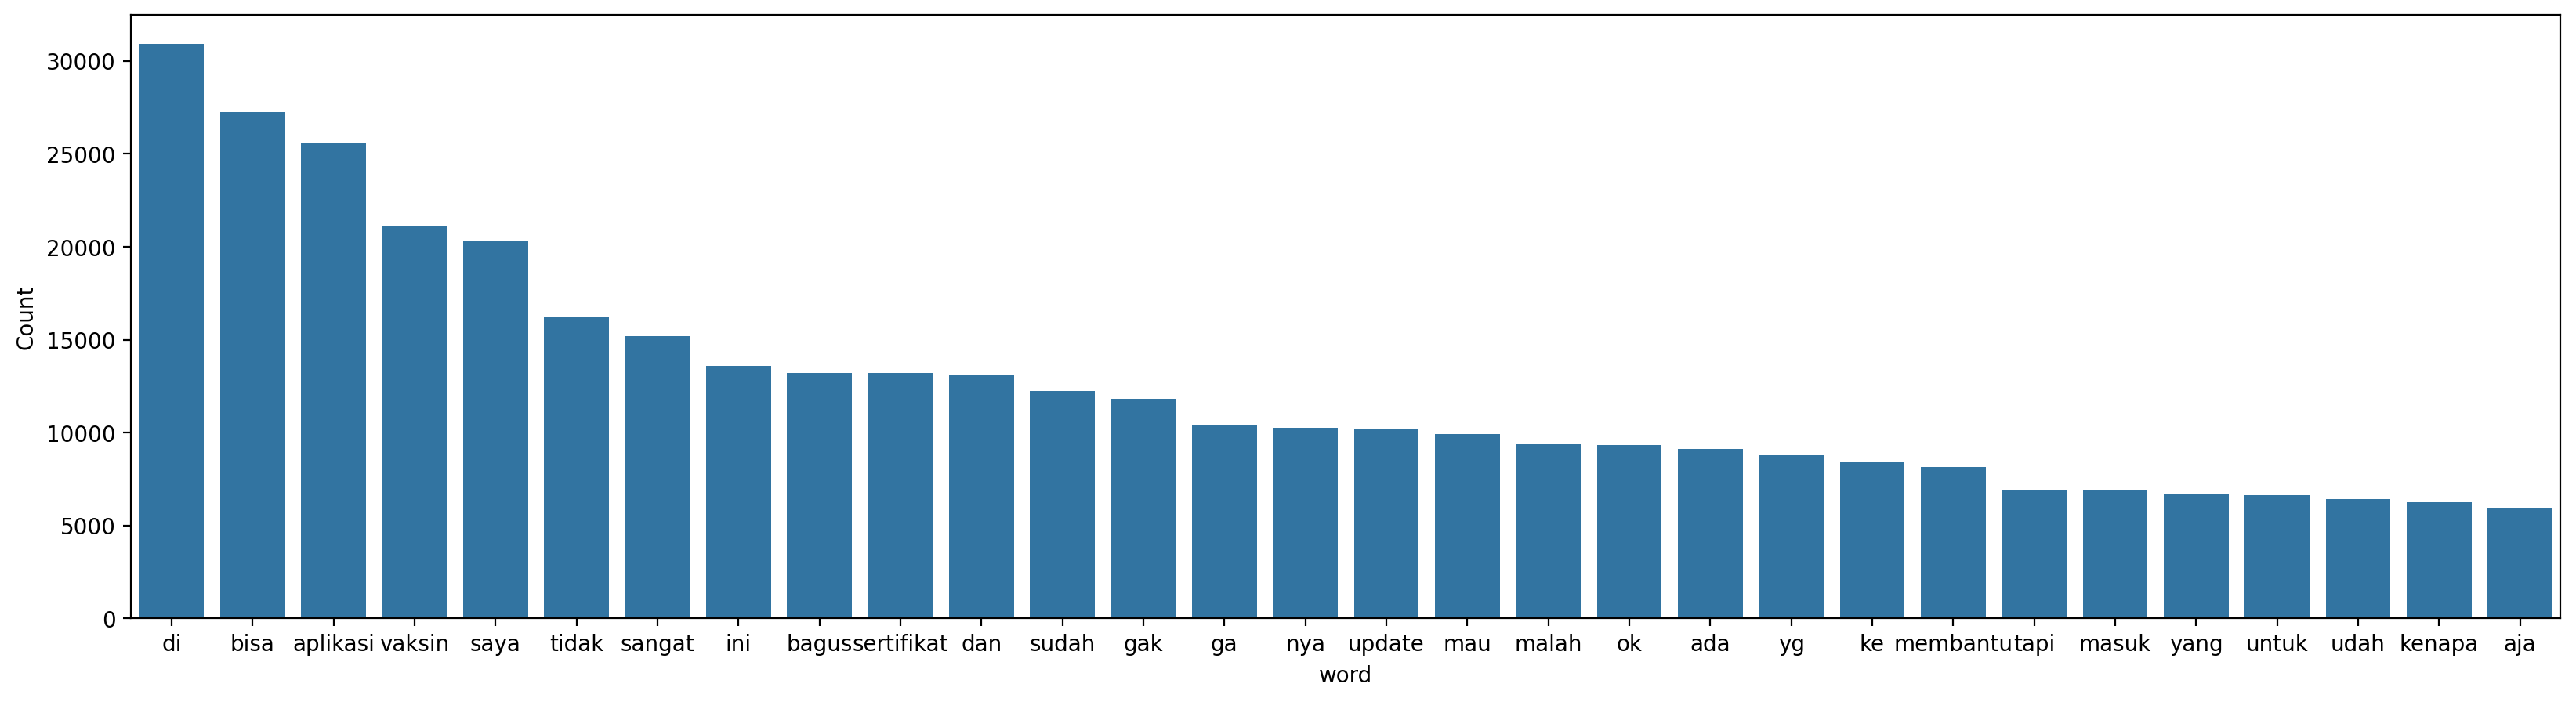

In [19]:
freq_words(df_satusehat['content'])

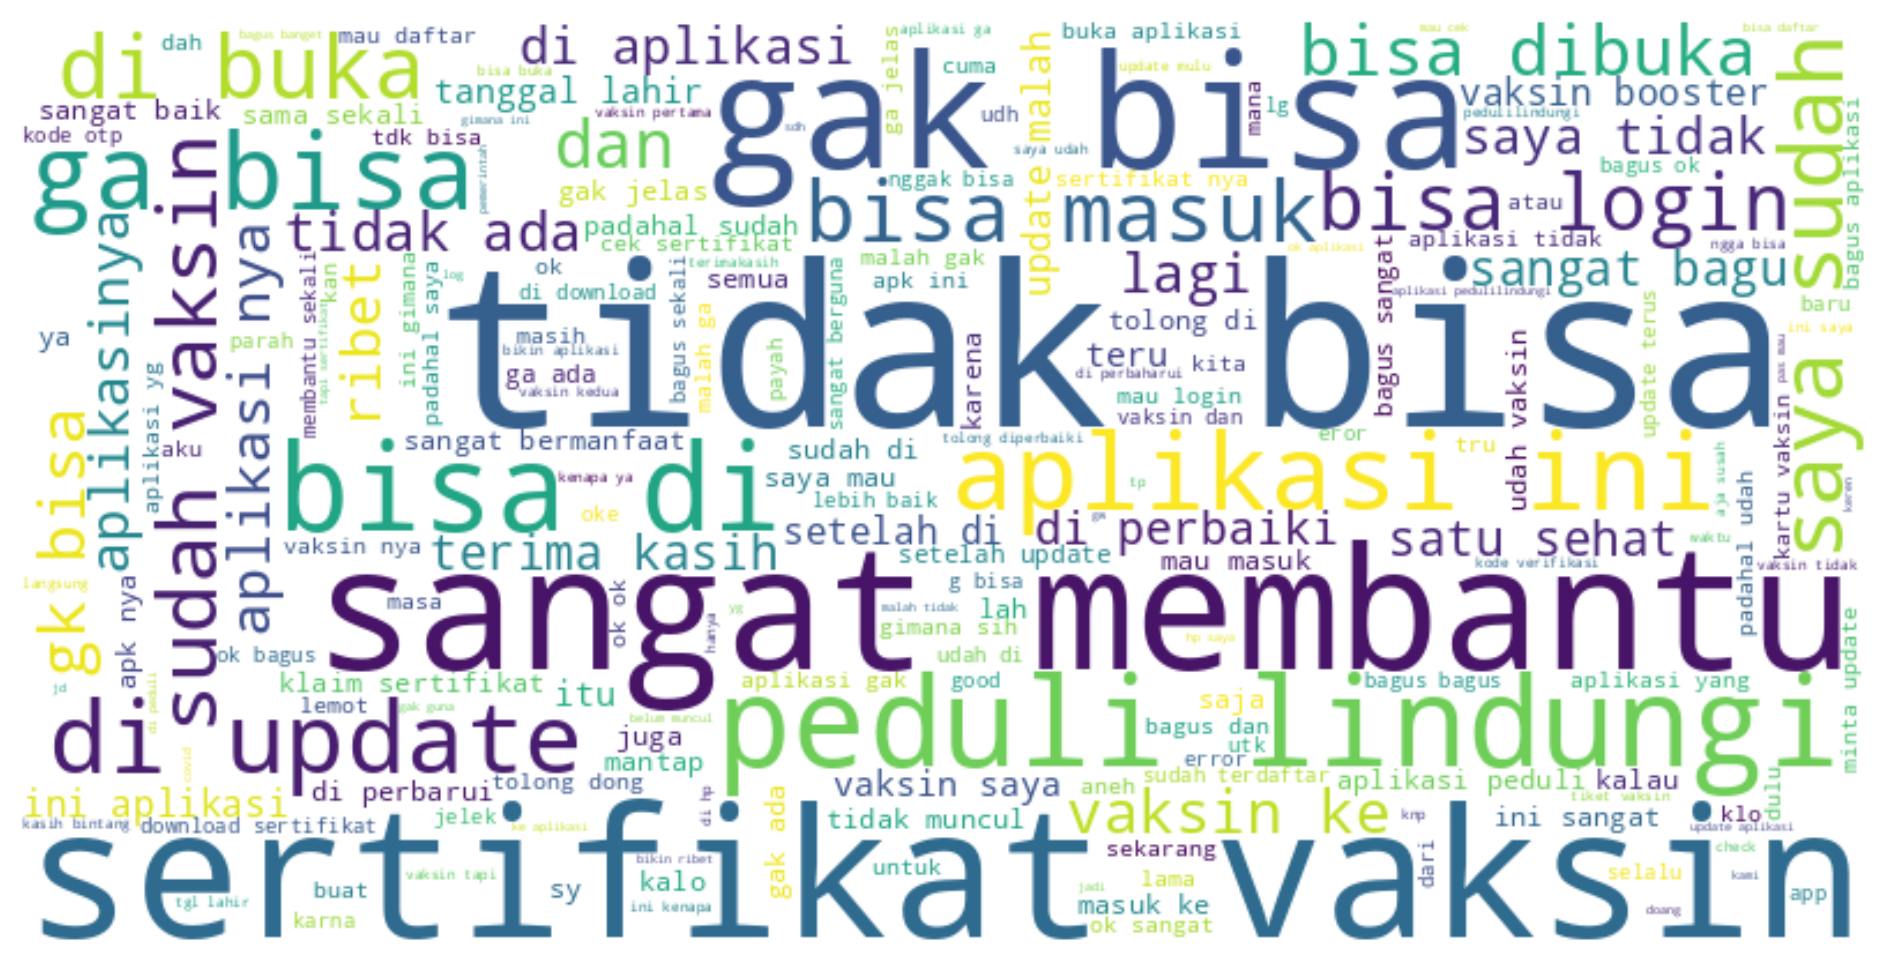

In [20]:
# Gabungkan semua kata dari kolom 'content' menjadi satu string
all_words_before = ' '.join(df_satusehat['content'])

# WordCloud sebelum menghapus stopwords
wordcloud_before = WordCloud(width=800, height=400, background_color='white').generate(all_words_before)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_before, interpolation='bilinear')
plt.axis('off')
plt.show()

In [25]:
# Menyimpan DataFrame ke dalam file CSV
file_path = 'df_satusehat_before_stopwords.csv'
df_satusehat.to_csv(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke df_satusehat_before_stopwords.csv


## Menghapus Tanda Baca

In [26]:
# Membuat dataframe baru
df_satusehat_stopwords = df_satusehat.loc[:,["content", "score", "sentiment_rating", "wordCount"]]
df_satusehat_stopwords['review_without_stopwords'] = df_satusehat_stopwords['content'].apply(
    lambda x: x.translate(str.maketrans("","",string.punctuation)))
df_satusehat_stopwords

content  score  \
0                              kalo gk niat gausah, jelek      1   
1       saya gak pernah gunakan tiba no saya ada dafta...      1   
2       dulu saat masih pedulilindungi saya sempat daf...      1   
3                                         membantu sekali      5   
4                         kenapa akun saya ga bisa log in      1   
...                                                   ...    ...   
149995                                    sangat membantu      5   
149996                                           mk...ķ x      4   
149997  gak bisa verfikasi..padahal data data saya sud...      1   
149998                                                gbu      5   
149999                                              bagus      4   

       sentiment_rating  wordCount  \
0              Negative          6   
1              Negative         12   
2              Negative         86   
3              Positive          2   
4              Negative          7   
...                 ...        ...   
149995         Positive          2   
149996         Positive          4   
149997         Negative         14   
149998         Positive          1   
149999         Positive          1   

                                 review_without_stopwords  
0                               kalo gk niat gausah jelek  
1       saya gak pernah gunakan tiba no saya ada dafta...  
2       dulu saat masih pedulilindungi saya sempat daf...  
3                                         membantu sekali  
4                         kenapa akun saya ga bisa log in  
...                                                   ...  
149995                                    sangat membantu  
149996                                              mkķ x  
149997  gak bisa verfikasipadahal data data saya sudah...  
149998                                                gbu  
149999                                              bagus  

[147595 rows x 5 columns]

## Menghapus Stopwords

In [27]:
import requests

# Unduh daftar stopwords dari URL
url = 'https://raw.githubusercontent.com/masdevid/ID-Stopwords/master/id.stopwords.02.01.2016.txt'
response = requests.get(url)

# Simpan daftar stopwords ke file lokal
with open('id_stopwords.txt', 'w') as file:
    file.write(response.text)

# Baca stopwords dari file
with open('id_stopwords.txt', 'r') as file:
    stopwords_id = file.read().splitlines()

# Menampilkan beberapa stopwords
print(f"Terdapat total {len(stopwords_id)} kata stopwords dalam bahasa Indonesia:")
print(stopwords_id[:10])  # Menampilkan 10 kata pertama dari daftar stopwords


Terdapat total 758 kata stopwords dalam bahasa Indonesia:
['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir']


In [28]:
# Fungsi untuk menghapus stopwords dari teks
def remove_stopwords(text, stopwords_list):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords_list]
    return ' '.join(filtered_words)

In [29]:
# Menghapus stopwords dari kolom 'review_without_stopwords'
df_satusehat_stopwords['review_without_stopwords'] = df_satusehat_stopwords['review_without_stopwords'].apply(
    lambda x: remove_stopwords(x, stopwords_id)
)

# Menampilkan hasil
df_satusehat_stopwords

content  score  \
0                              kalo gk niat gausah, jelek      1   
1       saya gak pernah gunakan tiba no saya ada dafta...      1   
2       dulu saat masih pedulilindungi saya sempat daf...      1   
3                                         membantu sekali      5   
4                         kenapa akun saya ga bisa log in      1   
...                                                   ...    ...   
149995                                    sangat membantu      5   
149996                                           mk...ķ x      4   
149997  gak bisa verfikasi..padahal data data saya sud...      1   
149998                                                gbu      5   
149999                                              bagus      4   

       sentiment_rating  wordCount  \
0              Negative          6   
1              Negative         12   
2              Negative         86   
3              Positive          2   
4              Negative          7   
...                 ...        ...   
149995         Positive          2   
149996         Positive          4   
149997         Negative         14   
149998         Positive          1   
149999         Positive          1   

                                 review_without_stopwords  
0                               kalo gk niat gausah jelek  
1                                    gak no daftar ya ane  
2       pedulilindungi daftar akun login web masuk amb...  
3                                                membantu  
4                                          akun ga log in  
...                                                   ...  
149995                                           membantu  
149996                                              mkķ x  
149997   gak verfikasipadahal data data lengkapgagal mulu  
149998                                                gbu  
149999                                              bagus  

[147595 rows x 5 columns]

In [30]:
# Fungsi untuk menghitung kata yang sering muncul
def freq_words(x, terms=30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})

    # Memilih kata yang paling sering muncul
    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(20, 5))
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel='Count')
    plt.show()

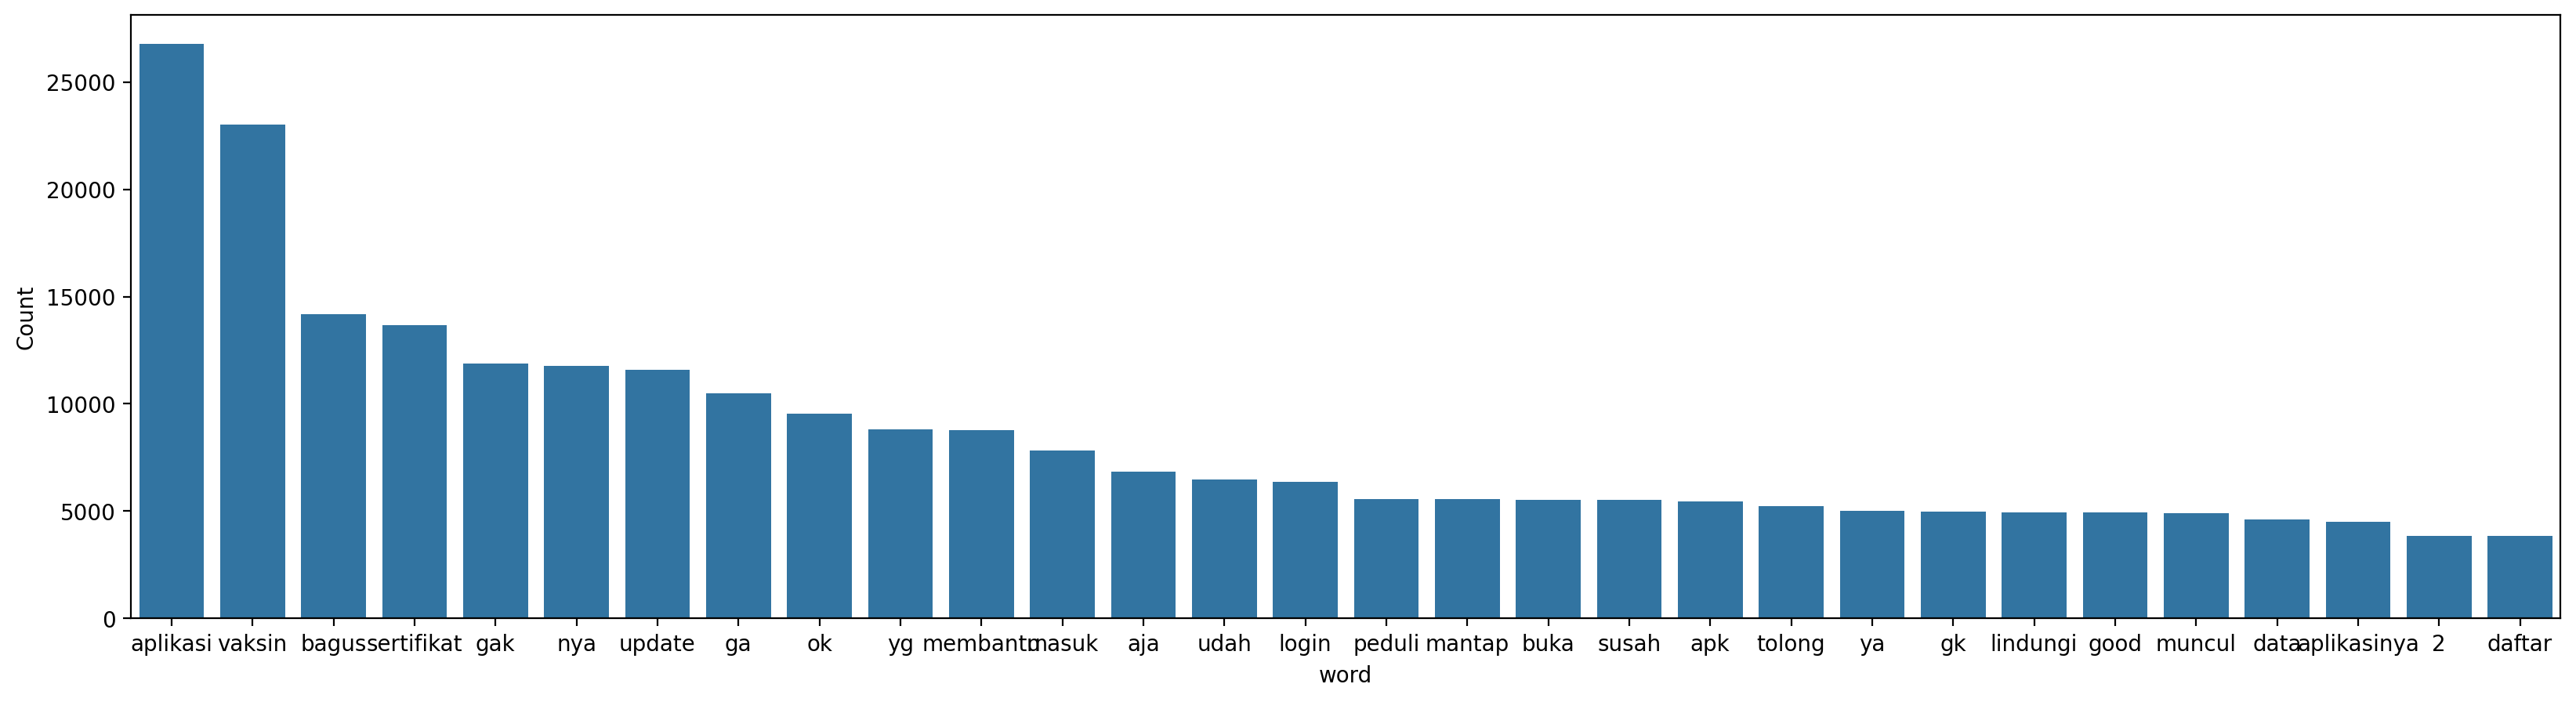

In [31]:
freq_words(df_satusehat_stopwords['review_without_stopwords'], terms=30)

In [32]:
stopwords_id = stopwords_id + ["nya", "yg", "ya", "aja"]

In [33]:
df_satusehat_stopwords['review_without_stopwords'] = df_satusehat_stopwords['review_without_stopwords'].apply(
    lambda x: remove_stopwords(x, stopwords_id)
)

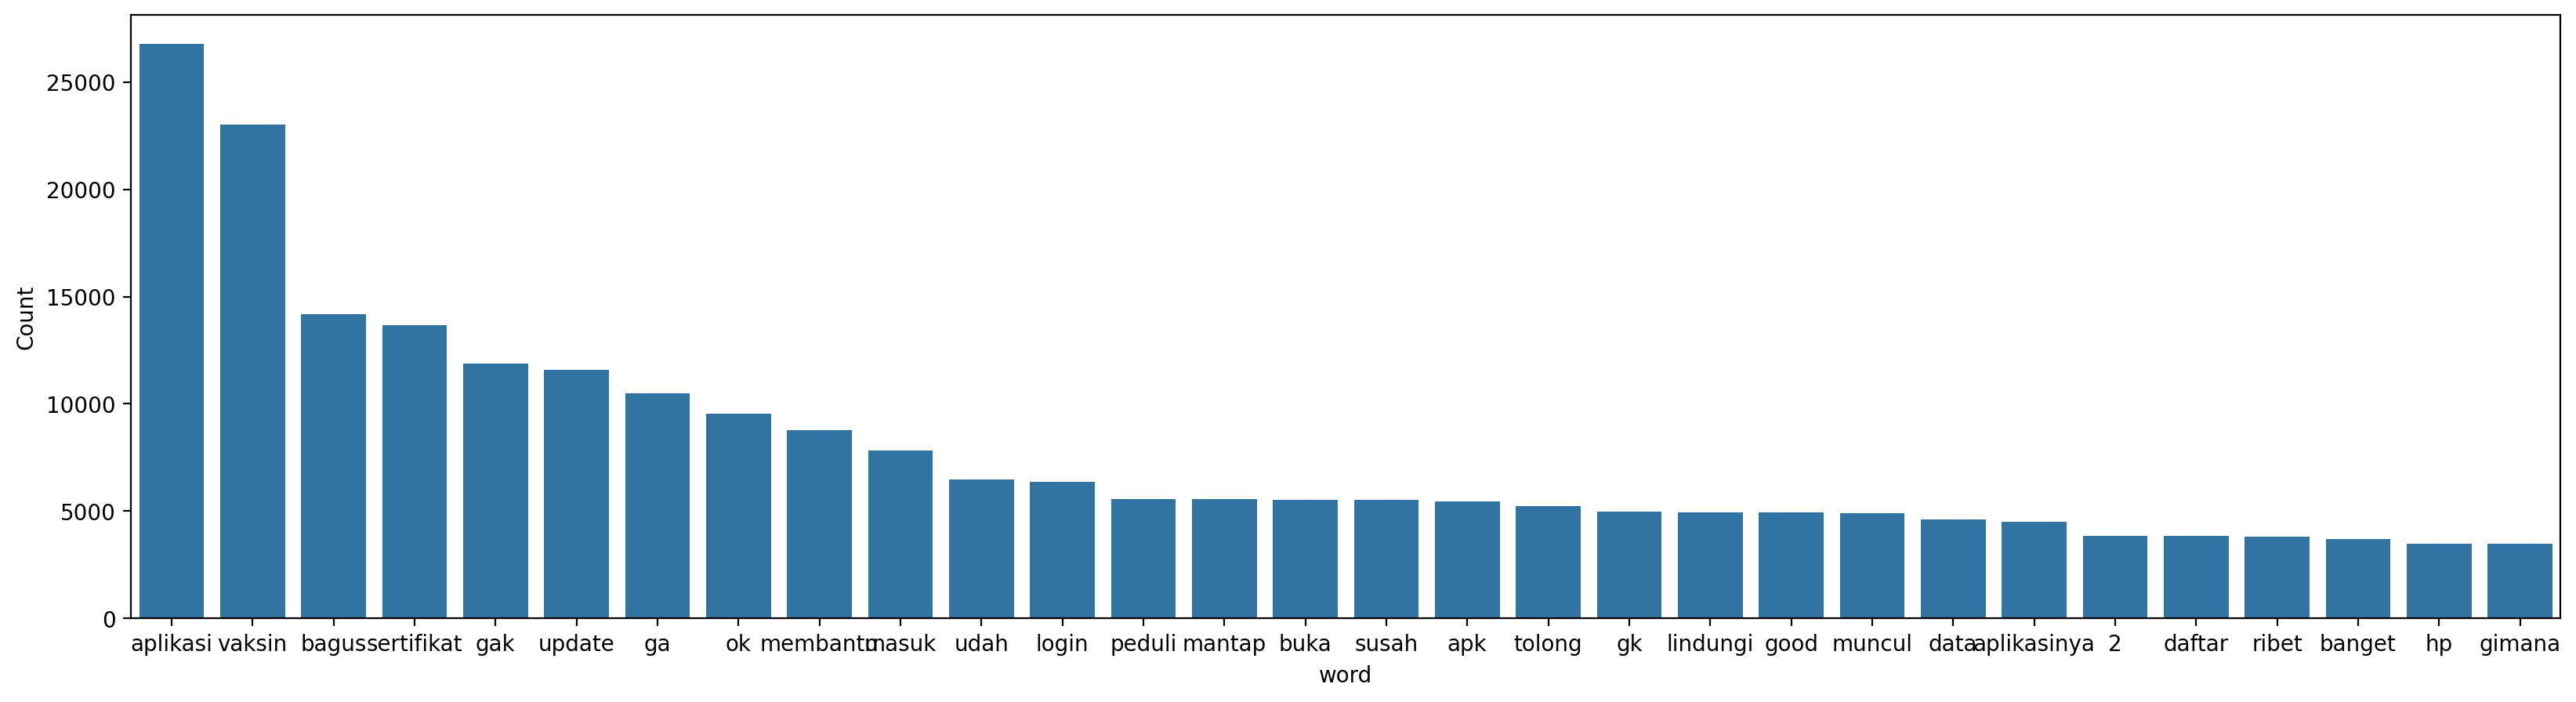

In [36]:
freq_words(df_satusehat_stopwords['review_without_stopwords'], terms=30)

# Text Analysis (Setelah Stopwords)

In [37]:
# Menghitung jumlah kata setelah menghapus stopwords
df_satusehat_stopwords['wordCount_after_stopwords'] = df_satusehat_stopwords['review_without_stopwords'].apply(
    lambda x: len(x.split())
)

In [38]:
df_satusehat_stopwords.loc[:,["content","score", "sentiment_rating","wordCount","review_without_stopwords", "wordCount_after_stopwords"]]

content  score  \
0                              kalo gk niat gausah, jelek      1   
1       saya gak pernah gunakan tiba no saya ada dafta...      1   
2       dulu saat masih pedulilindungi saya sempat daf...      1   
3                                         membantu sekali      5   
4                         kenapa akun saya ga bisa log in      1   
...                                                   ...    ...   
149995                                    sangat membantu      5   
149996                                           mk...ķ x      4   
149997  gak bisa verfikasi..padahal data data saya sud...      1   
149998                                                gbu      5   
149999                                              bagus      4   

       sentiment_rating  wordCount  \
0              Negative          6   
1              Negative         12   
2              Negative         86   
3              Positive          2   
4              Negative          7   
...                 ...        ...   
149995         Positive          2   
149996         Positive          4   
149997         Negative         14   
149998         Positive          1   
149999         Positive          1   

                                 review_without_stopwords  \
0                               kalo gk niat gausah jelek   
1                                       gak no daftar ane   
2       pedulilindungi daftar akun login web masuk amb...   
3                                                membantu   
4                                          akun ga log in   
...                                                   ...   
149995                                           membantu   
149996                                              mkķ x   
149997   gak verfikasipadahal data data lengkapgagal mulu   
149998                                                gbu   
149999                                              bagus   

        wordCount_after_stopwords  
0                               5  
1                               4  
2                              38  
3                               1  
4                               4  
...                           ...  
149995                          1  
149996                          2  
149997                          6  
149998                          1  
149999                          1  

[147595 rows x 6 columns]

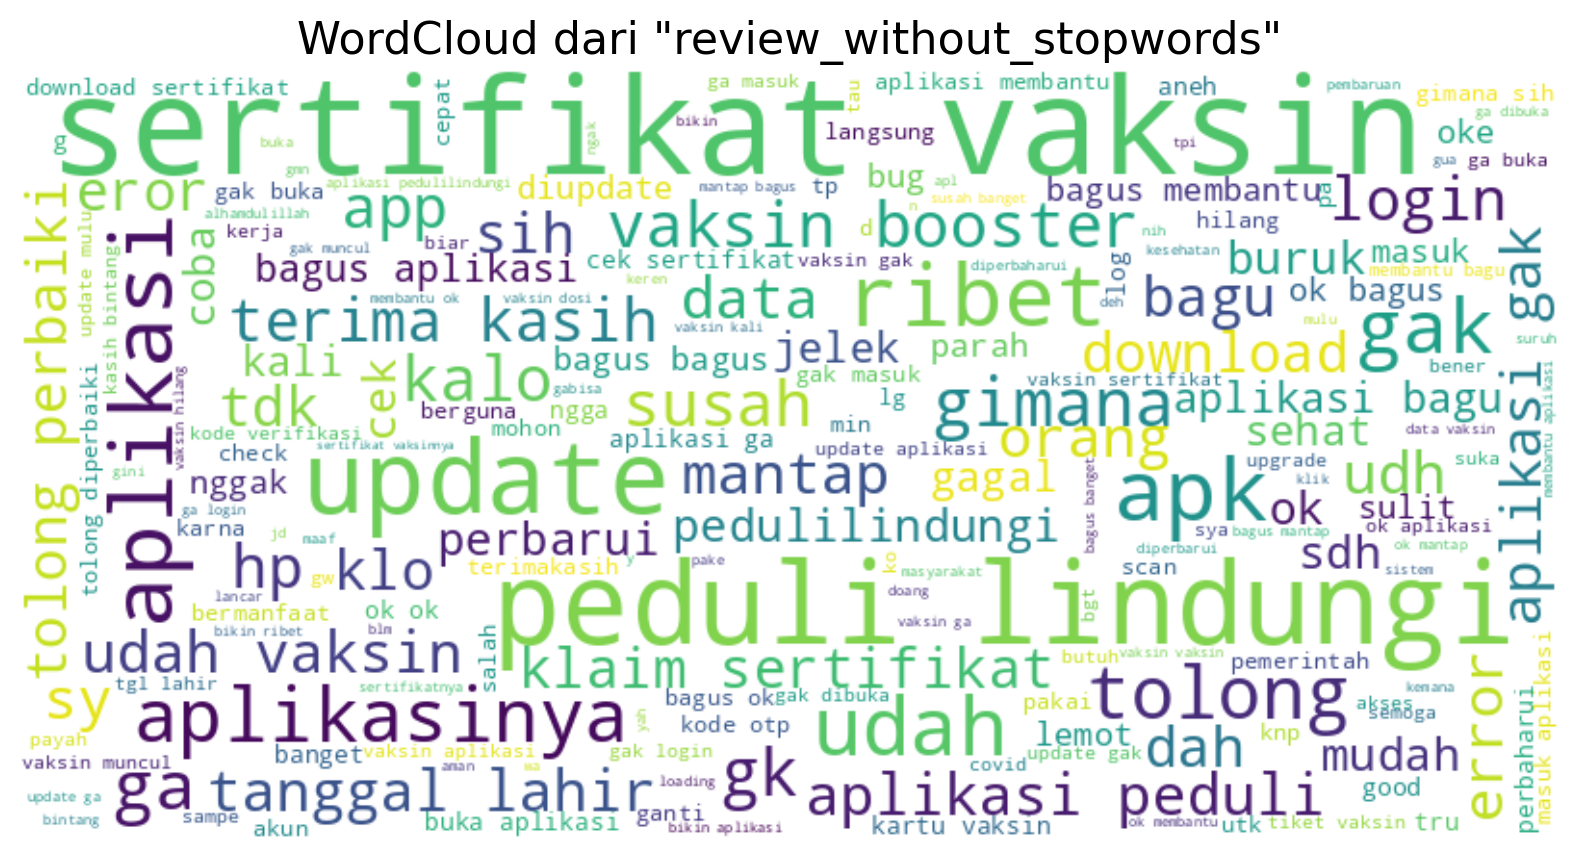

In [39]:
# Gabungkan semua teks dari kolom 'review_without_stopwords' menjadi satu string
text = ' '.join(df_satusehat_stopwords['review_without_stopwords'].astype(str))

# Buat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Menghilangkan sumbu
plt.title('WordCloud dari "review_without_stopwords"', fontsize=16)
plt.show()

In [40]:
# Menyimpan DataFrame ke dalam file Excel
file_path = 'satusehat_df_after_stopwords.xlsx'
df_satusehat_stopwords.to_excel(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke satusehat_news_df_after_stopwords.xlsx


# Stemming

In [41]:
# Mengunduh library untuk stemming Bahasa Indonesia
!pip install PySastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 11.5 MB/s eta 0:00:00


In [42]:
# Import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [43]:
# Fungsi untuk stemming
def stemming_indonesia(text):
    if text is not None:
        # Lakukan stemming dan kembalikan hasilnya
        return stemmer.stem(text)
    return ''

In [45]:
# Terapkan stemming pada kolom 'review_without_stopwords'
df_satusehat_stopwords['review_stem_without_stopwords'] = df_satusehat_stopwords['review_without_stopwords'].apply(stemming_indonesia)

# Menampilkan hasil untuk beberapa baris
df_satusehat_stopwords.loc[0:3, ['review_without_stopwords', 'review_stem_without_stopwords']]

review_without_stopwords  \
0                          kalo gk niat gausah jelek   
1                                  gak no daftar ane   
2  pedulilindungi daftar akun login web masuk amb...   
3                                           membantu   

                       review_stem_without_stopwords  
0                          kalo gk niat gausah jelek  
1                                  gak no daftar ane  
2  pedulilindungi daftar akun login web masuk amb...  
3                                              bantu

In [46]:
df_satusehat_stopwords['wordcount_stem_without_stopwords'] = df_satusehat_stopwords['review_stem_without_stopwords'].apply(lambda x: len(x.split()))

In [48]:
df_satusehat_stopwords.loc[:,['content', 'wordCount', 'review_stem_without_stopwords', 'wordcount_stem_without_stopwords']]

content  wordCount  \
0                              kalo gk niat gausah, jelek          6   
1       saya gak pernah gunakan tiba no saya ada dafta...         12   
2       dulu saat masih pedulilindungi saya sempat daf...         86   
3                                         membantu sekali          2   
4                         kenapa akun saya ga bisa log in          7   
...                                                   ...        ...   
149995                                    sangat membantu          2   
149996                                           mk...ķ x          4   
149997  gak bisa verfikasi..padahal data data saya sud...         14   
149998                                                gbu          1   
149999                                              bagus          1   

                            review_stem_without_stopwords  \
0                               kalo gk niat gausah jelek   
1                                       gak no daftar ane   
2       pedulilindungi daftar akun login web masuk amb...   
3                                                   bantu   
4                                          akun ga log in   
...                                                   ...   
149995                                              bantu   
149996                                               mk x   
149997   gak verfikasipadahal data data lengkapgagal mulu   
149998                                                gbu   
149999                                              bagus   

        wordcount_stem_without_stopwords  
0                                      5  
1                                      4  
2                                     38  
3                                      1  
4                                      4  
...                                  ...  
149995                                 1  
149996                                 2  
149997                                 6  
149998                                 1  
149999                                 1  

[147595 rows x 4 columns]

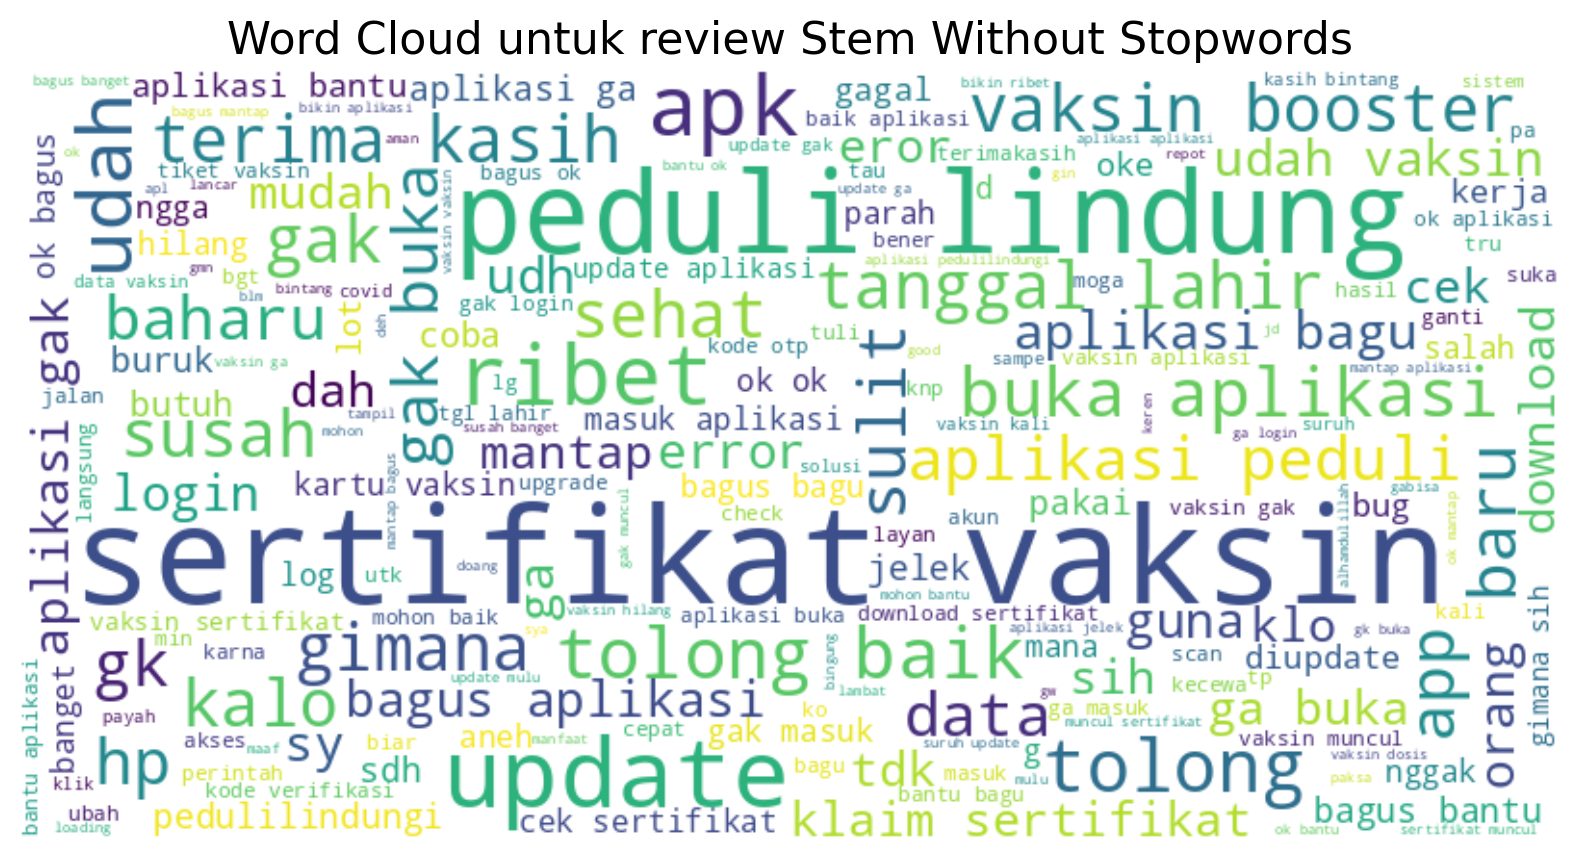

In [49]:
# Buat Word Cloud untuk 'review_stem_without_stopwords'
wordcloud_stem = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_satusehat_stopwords['review_stem_without_stopwords']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_stem, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk review Stem Without Stopwords', fontsize=16)
plt.show()

In [50]:
# Menyimpan DataFrame ke dalam file Excel
file_path = 'satusehat_df_after_stopwords_stemming.xlsx'
df_satusehat_stopwords.to_excel(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke satusehat_df_after_stopwords_stemming.xlsx


# Lemmatization

In [51]:
from nltk.stem import WordNetLemmatizer

# Unduh data yang diperlukan untuk lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

# Buat objek lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [52]:
# Fungsi untuk melakukan lemmatization
def lemmatize_indonesia(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [53]:
# Terapkan lemmatization pada kolom 'review_without_stopwords'
df_satusehat_stopwords['content_lemmatized'] = df_satusehat_stopwords['review_without_stopwords'].apply(lemmatize_indonesia)

# Menampilkan hasil untuk beberapa baris
df_satusehat_stopwords.loc[0:3, ['review_without_stopwords', 'content_lemmatized']]

review_without_stopwords  \
0                          kalo gk niat gausah jelek   
1                                  gak no daftar ane   
2  pedulilindungi daftar akun login web masuk amb...   
3                                           membantu   

                                  content_lemmatized  
0                          kalo gk niat gausah jelek  
1                                  gak no daftar ane  
2  pedulilindungi daftar akun login web masuk amb...  
3                                           membantu

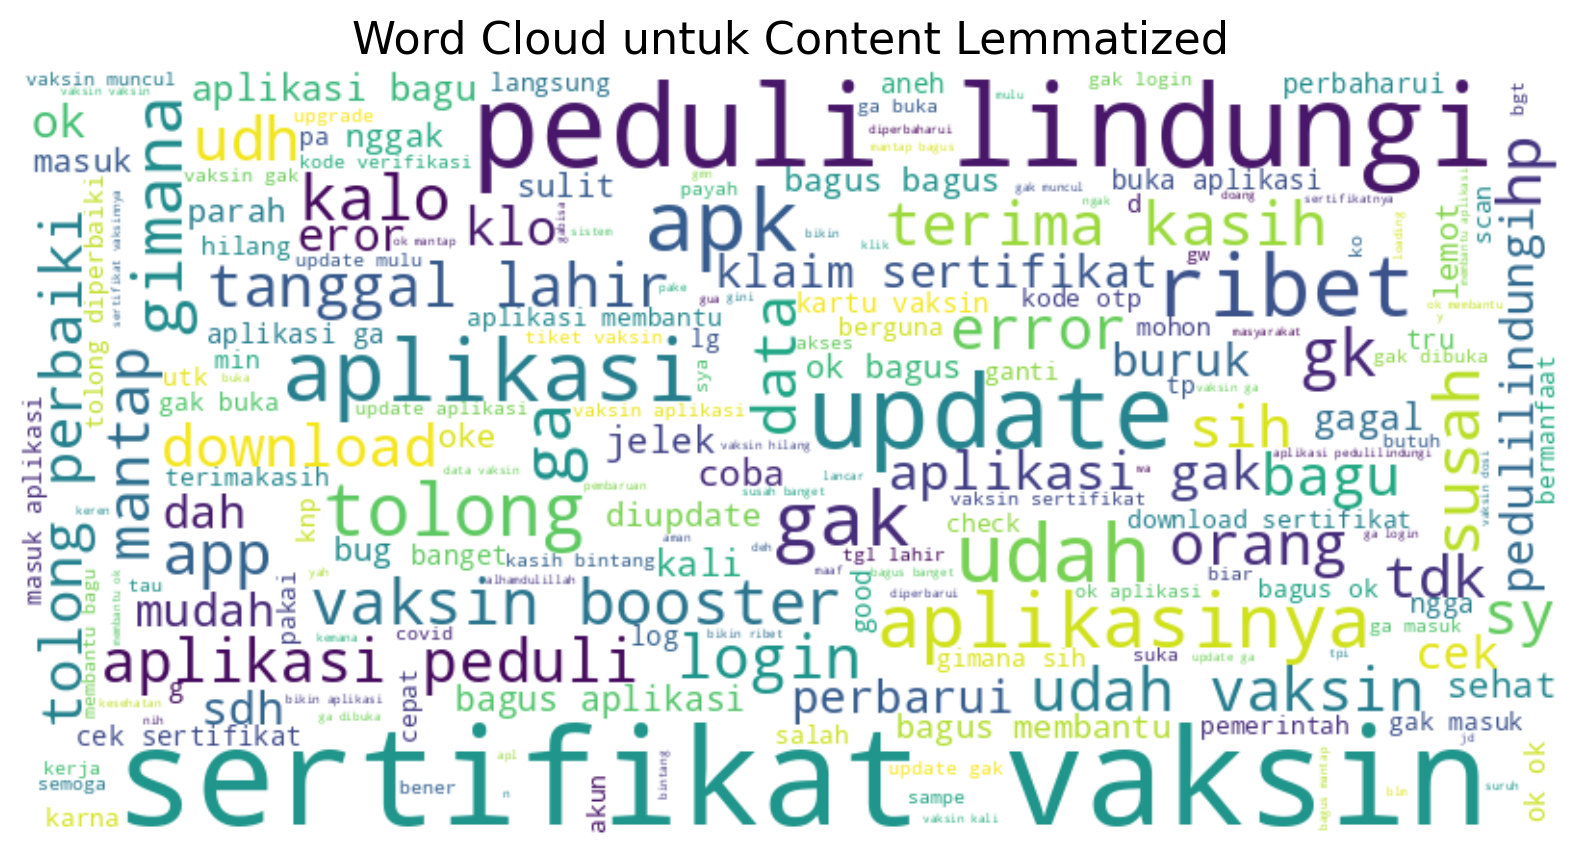

In [54]:
wordcloud_lemmatized = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_satusehat_stopwords['content_lemmatized']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_lemmatized, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud untuk Content Lemmatized', fontsize=16)
plt.show()


In [55]:
# Menyimpan DataFrame ke dalam file Excel
file_path = 'satusehat_df_after_stopwords_lemm.xlsx'
df_satusehat_stopwords.to_excel(file_path, index=False)

print(f"DataFrame telah disimpan ke {file_path}")

DataFrame telah disimpan ke satusehat_df_after_stopwords_lemm.xlsx


# Analisis Lanjutan

In [56]:
df_satusehat_stopwords

content  score  \
0                              kalo gk niat gausah, jelek      1   
1       saya gak pernah gunakan tiba no saya ada dafta...      1   
2       dulu saat masih pedulilindungi saya sempat daf...      1   
3                                         membantu sekali      5   
4                         kenapa akun saya ga bisa log in      1   
...                                                   ...    ...   
149995                                    sangat membantu      5   
149996                                           mk...ķ x      4   
149997  gak bisa verfikasi..padahal data data saya sud...      1   
149998                                                gbu      5   
149999                                              bagus      4   

       sentiment_rating  wordCount  \
0              Negative          6   
1              Negative         12   
2              Negative         86   
3              Positive          2   
4              Negative          7   
...                 ...        ...   
149995         Positive          2   
149996         Positive          4   
149997         Negative         14   
149998         Positive          1   
149999         Positive          1   

                                 review_without_stopwords  \
0                               kalo gk niat gausah jelek   
1                                       gak no daftar ane   
2       pedulilindungi daftar akun login web masuk amb...   
3                                                membantu   
4                                          akun ga log in   
...                                                   ...   
149995                                           membantu   
149996                                              mkķ x   
149997   gak verfikasipadahal data data lengkapgagal mulu   
149998                                                gbu   
149999                                              bagus   

        wordCount_after_stopwords  \
0                               5   
1                               4   
2                              38   
3                               1   
4                               4   
...                           ...   
149995                          1   
149996                          2   
149997                          6   
149998                          1   
149999                          1   

                            review_stem_without_stopwords  \
0                               kalo gk niat gausah jelek   
1                                       gak no daftar ane   
2       pedulilindungi daftar akun login web masuk amb...   
3                                                   bantu   
4                                          akun ga log in   
...                                                   ...   
149995                                              bantu   
149996                                               mk x   
149997   gak verfikasipadahal data data lengkapgagal mulu   
149998                                                gbu   
149999                                              bagus   

        wordcount_stem_without_stopwords  \
0                                      5   
1                                      4   
2                                     38   
3                                      1   
4                                      4   
...                                  ...   
149995                                 1   
149996                                 2   
149997                                 6   
149998                                 1   
149999                                 1   

                                       content_lemmatized  
0                               kalo gk niat gausah jelek  
1                                       gak no daftar ane  
2       pedulilindungi daftar akun login web masuk amb...  
3                                                membantu  
4                                   

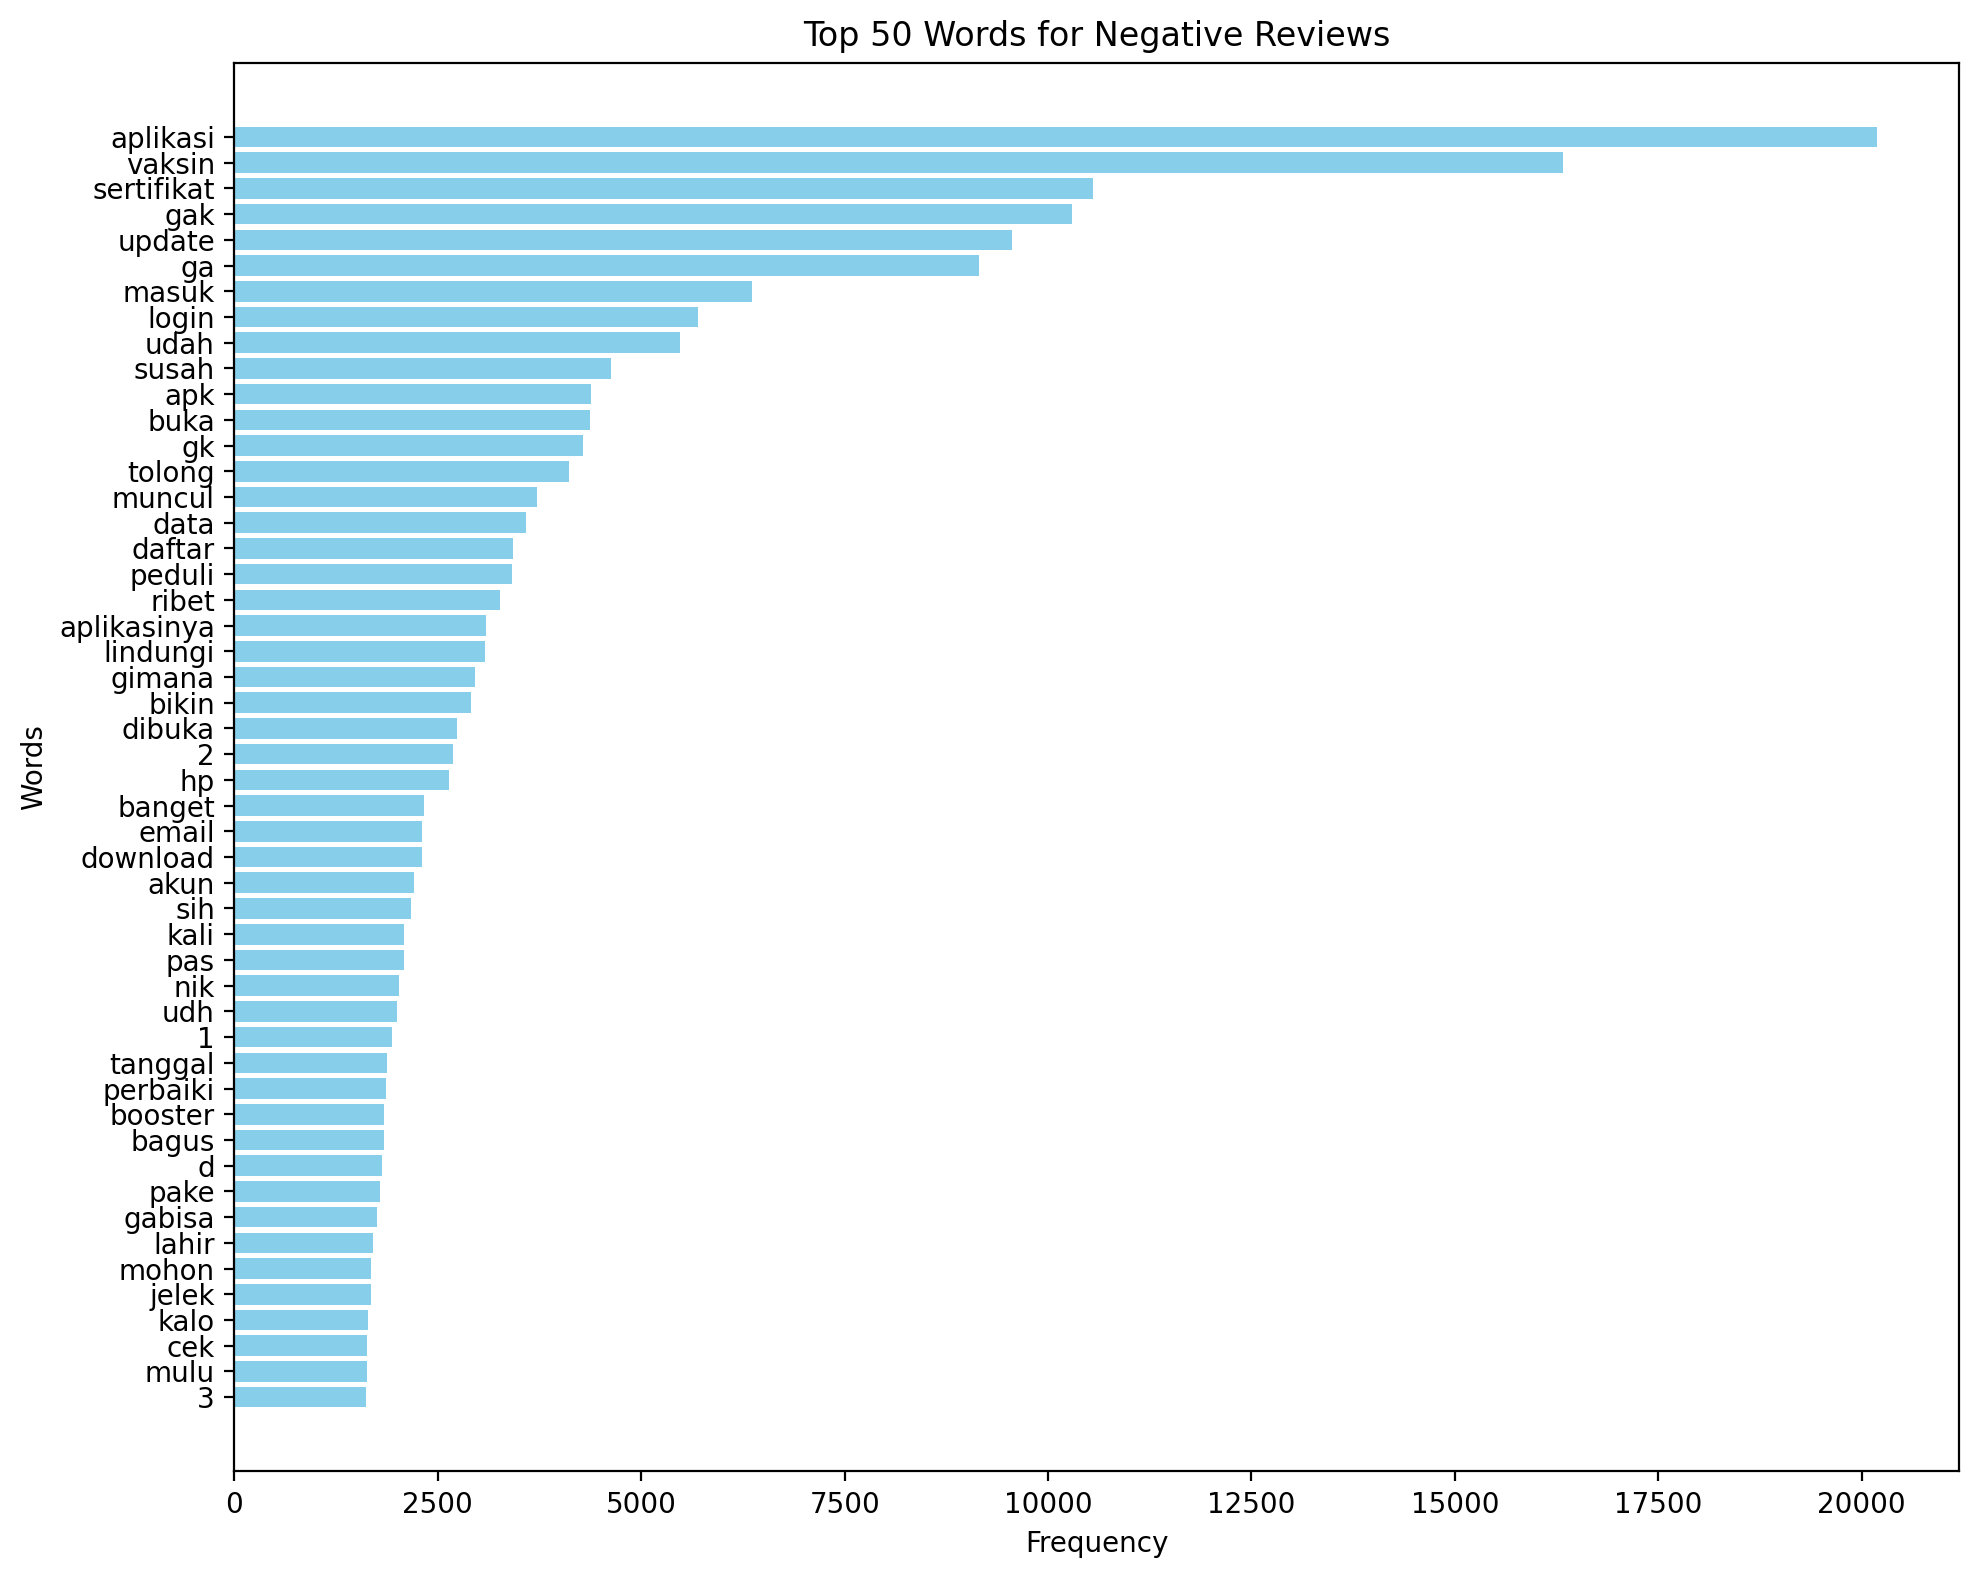

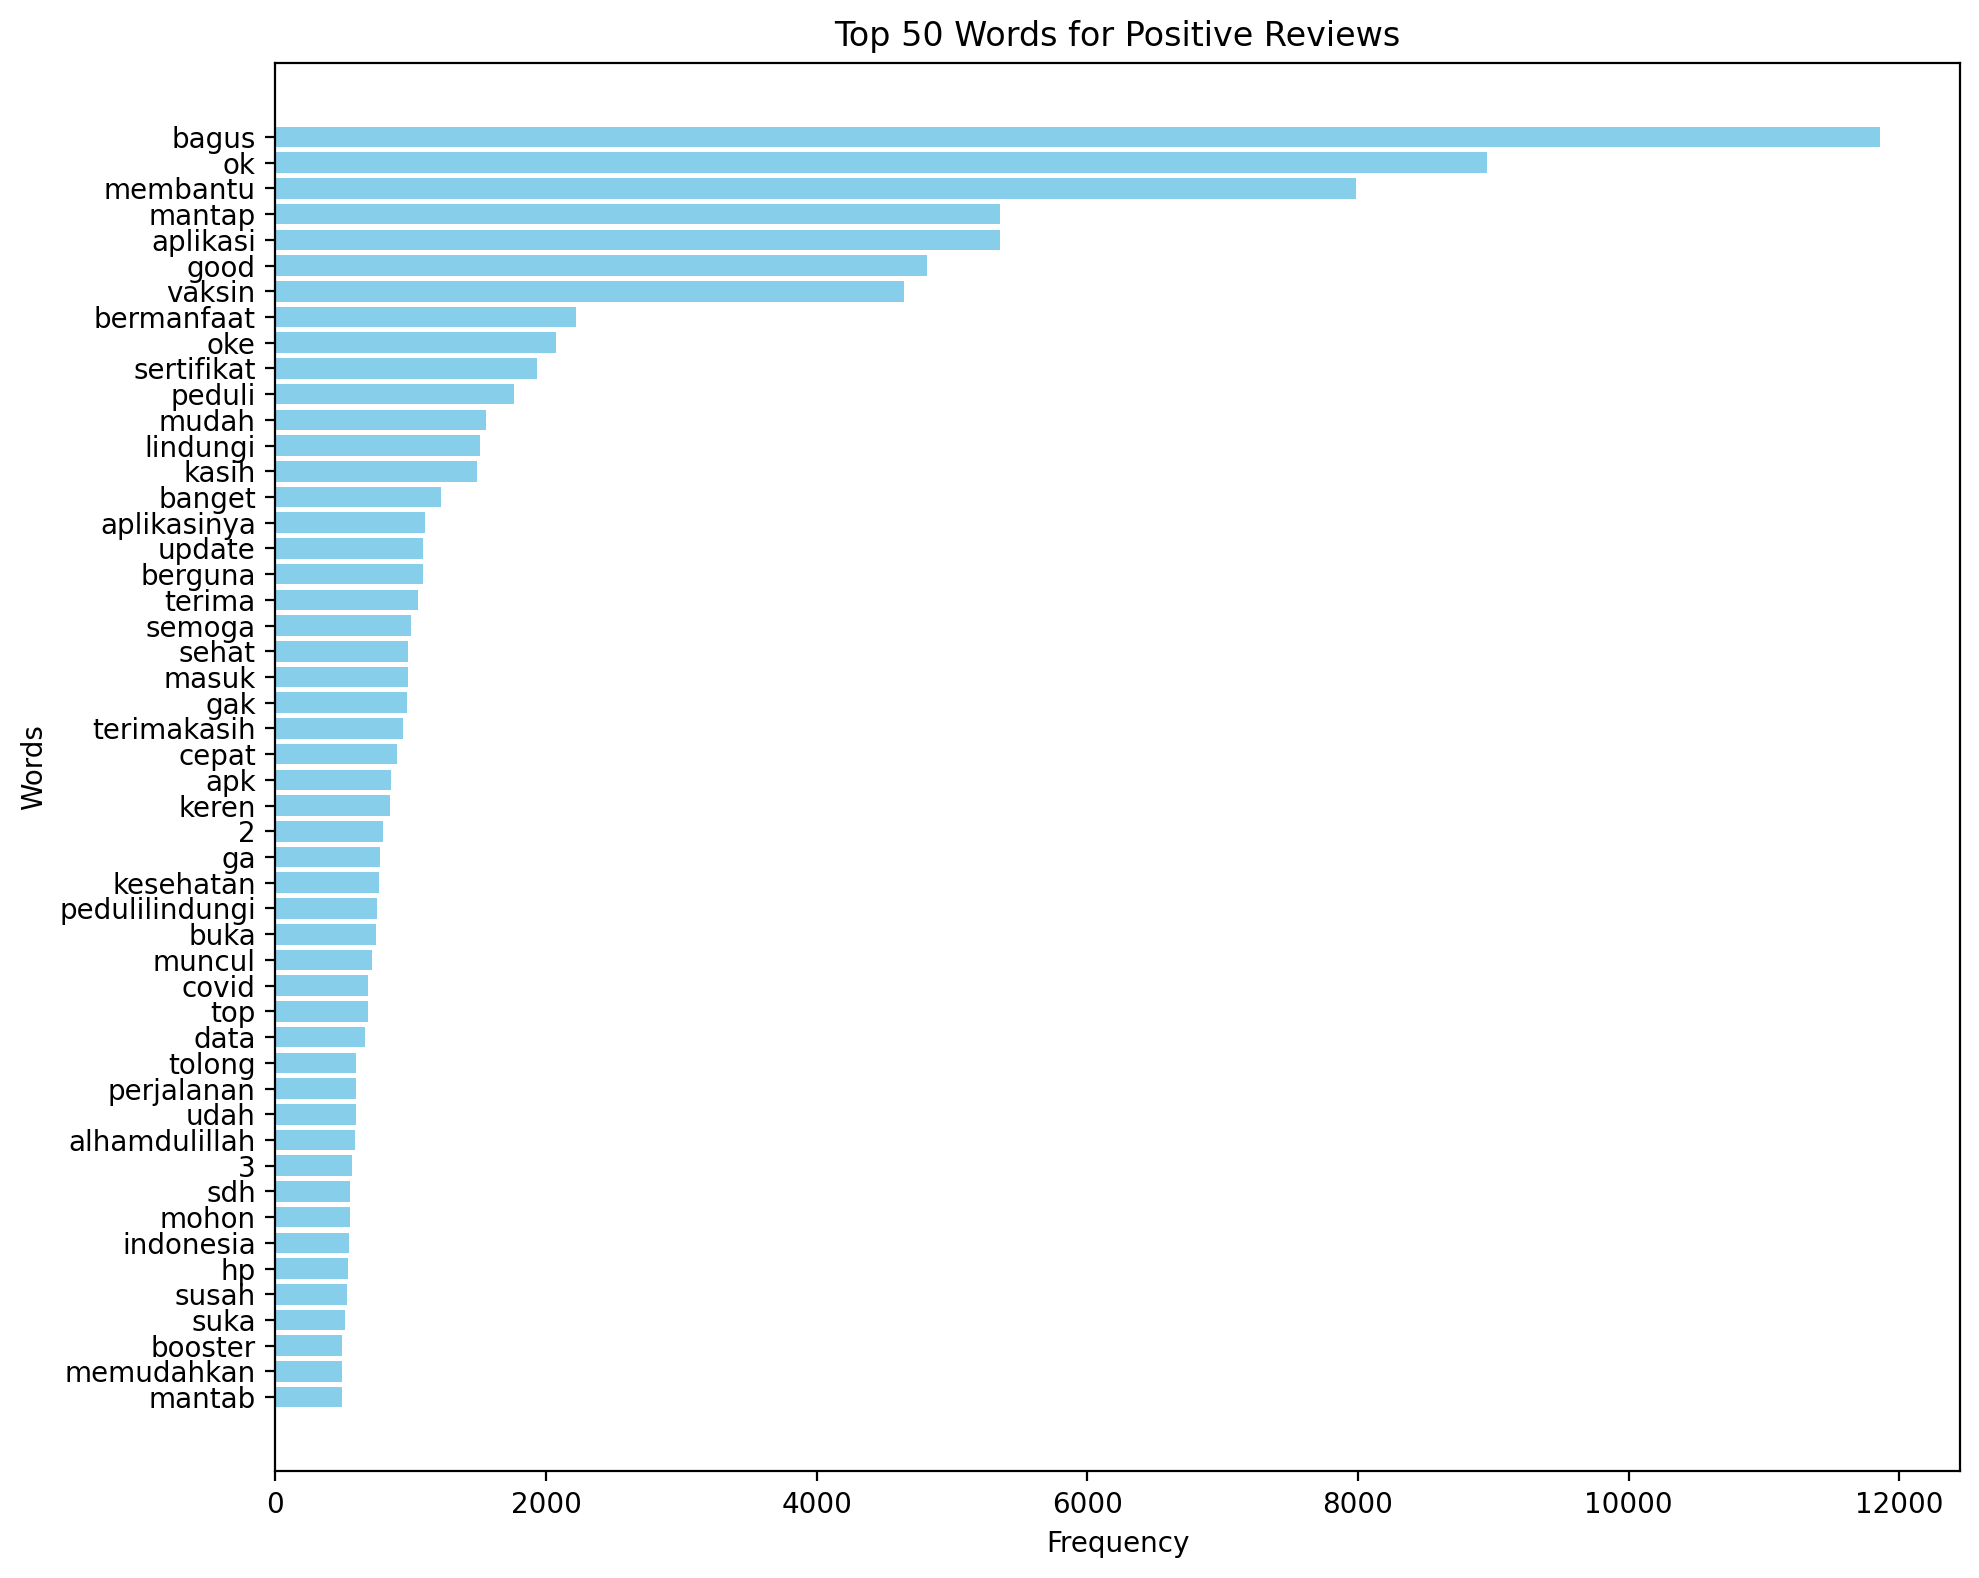

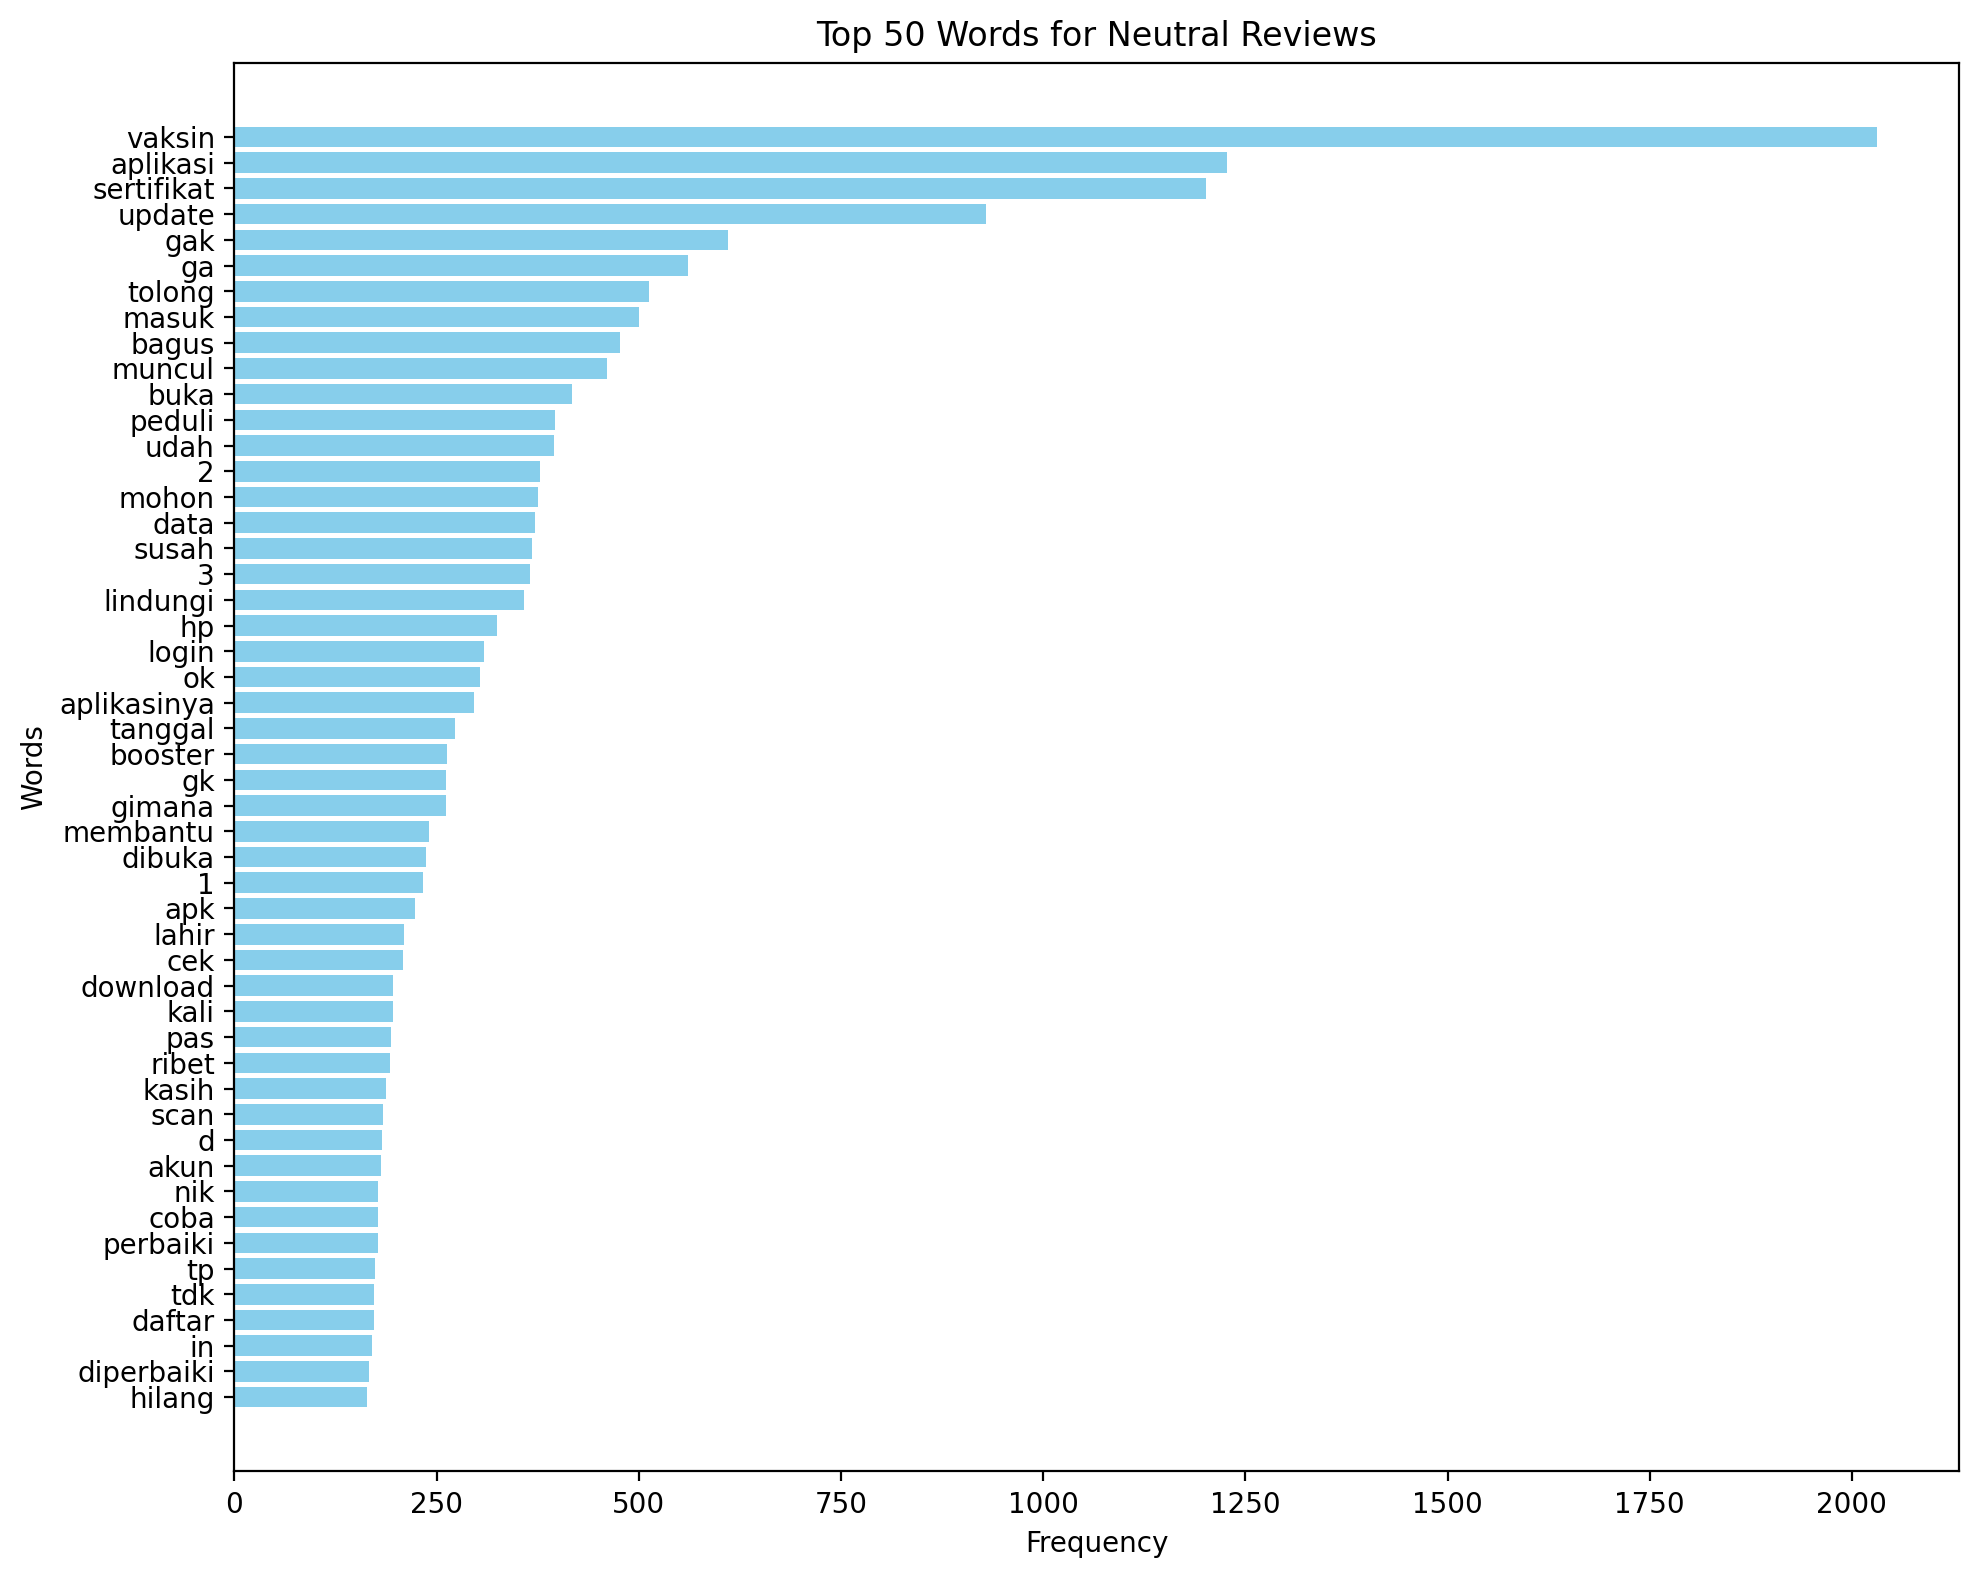

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import STOPWORDS

# Filter data berdasarkan nilai sentiment_rating
negative_reviews = df_satusehat_stopwords[df_satusehat_stopwords['sentiment_rating'] == 'Negative']
positive_reviews = df_satusehat_stopwords[df_satusehat_stopwords['sentiment_rating'] == 'Positive']
neutral_reviews = df_satusehat_stopwords[df_satusehat_stopwords['sentiment_rating'] == 'Neutral']

# Fungsi untuk menghitung frekuensi kata
def get_top_words(text_series, top_n=50):
    all_words = ' '.join(text_series).split()
    counter = Counter(all_words)
    return counter.most_common(top_n)

# Mendapatkan top 50 kata
top_negative = get_top_words(negative_reviews['review_without_stopwords'])
top_positive = get_top_words(positive_reviews['review_without_stopwords'])
top_neutral = get_top_words(neutral_reviews['review_without_stopwords'])

# Fungsi untuk visualisasi
def plot_top_words(word_counts, sentiment_label):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(10, 8))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top 50 Words for {sentiment_label} Reviews')
    plt.gca().invert_yaxis()  # Membalikkan urutan agar frekuensi tertinggi di atas
    plt.tight_layout()
    plt.show()

# Visualisasi untuk masing-masing kategori
plot_top_words(top_negative, 'Negative')
plot_top_words(top_positive, 'Positive')
plot_top_words(top_neutral, 'Neutral')


# POS

In [59]:
import nltk
import pandas as pd
from collections import Counter
from textblob import TextBlob

# Store all POS tags and words
all_words = []
all_pos_tags = []
word_pos_map = {}

# Loop through each review in 'review_without_stopwords' column
for content in df_satusehat_stopwords['review_without_stopwords']:
    if isinstance(content, str) and content.strip():  # Check if content is a non-empty string
        text = TextBlob(content)  # Process the content using TextBlob for POS tagging
        pos_tags = text.tags  # Get POS tags

        # Collect words and their corresponding POS tags
        for word, pos in pos_tags:
            word_lower = word.lower()
            all_words.append(word_lower)
            all_pos_tags.append(pos)

            # Map each POS tag with the corresponding word
            if pos in word_pos_map:
                word_pos_map[pos].append(word_lower)
            else:
                word_pos_map[pos] = [word_lower]

# Calculate count of POS tags
pos_counts = Counter(all_pos_tags)

# Calculate unique tokens for each POS tag
unique_tokens_count = {pos: len(set(words)) for pos, words in word_pos_map.items()}

# Prepare data for the DataFrame
tag_data = []
for pos, count in pos_counts.items():
    unique_tokens = unique_tokens_count.get(pos, 0)
    tag_data.append({'Tag': pos, 'Count': count, 'Unique Tokens': unique_tokens})

# Create DataFrame
pos_df = pd.DataFrame(tag_data)

# Display the DataFrame
print(pos_df)


     Tag   Count  Unique Tokens
0     NN  599437          43901
1     JJ   86266           8283
2     DT    2844             37
3     CD   17608           1759
4     WP    3715             74
5    VBZ    6323           1543
6     IN    6360            633
7     FW    7583           1115
8    VBD    9463           1921
9    NNS   17842           2228
10   VBP   10911           2644
11    RB    4221            740
12   VBG    2653            426
13    RP     571             25
14    VB    2130            708
15   PRP     432             19
16   VBN     561            126
17    MD     356             77
18    UH      37              2
19    CC    1240            250
20   RBS      50             23
21   JJS     344             11
22   WRB     118             28
23   NNP    1310            467
24   PDT      10              5
25    TO     211              2
26  PRP$     109              7
27   JJR      94             44
28   WDT      11              5
29   RBR      27             10
30    EX

In [60]:
# Download the CSV
pos_df.to_csv('pos_tag_counts_satusehat_google_play_review.csv', index=False)

### Menghitung Frekuensi Kata dan POS

In [61]:
# Count word frequency
word_counts = Counter(all_words)

# Count POS tag frequency
pos_counts = Counter(all_pos_tags)

# Display the most common words and POS tags
print("Top 10 most common words:", word_counts.most_common(10))
print("Top 10 most common POS tags:", pos_counts.most_common(10))

Top 10 most common words: [('aplikasi', 26768), ('vaksin', 22642), ('bagus', 14168), ('sertifikat', 13683), ('gak', 11878), ('update', 11582), ('ga', 10479), ('ok', 9549), ('membantu', 8768), ('masuk', 7835)]
Top 10 most common POS tags: [('NN', 599437), ('JJ', 86266), ('NNS', 17842), ('CD', 17608), ('VBP', 10911), ('VBD', 9463), ('FW', 7583), ('IN', 6360), ('VBZ', 6323), ('RB', 4221)]


# NER

                            review_without_stopwords  \
0                          kalo gk niat gausah jelek   
1                                  gak no daftar ane   
2  pedulilindungi daftar akun login web masuk amb...   
3                                           membantu   
4                                     akun ga log in   

                                        ner_entities  
0                           [(gausah jelek, PERSON)]  
1                             [(gak no daftar, ORG)]  
2  [(pedulilindungi daftar, PERSON), (1, CARDINAL...  
3                                                 []  
4                                   [(akun ga, ORG)]  


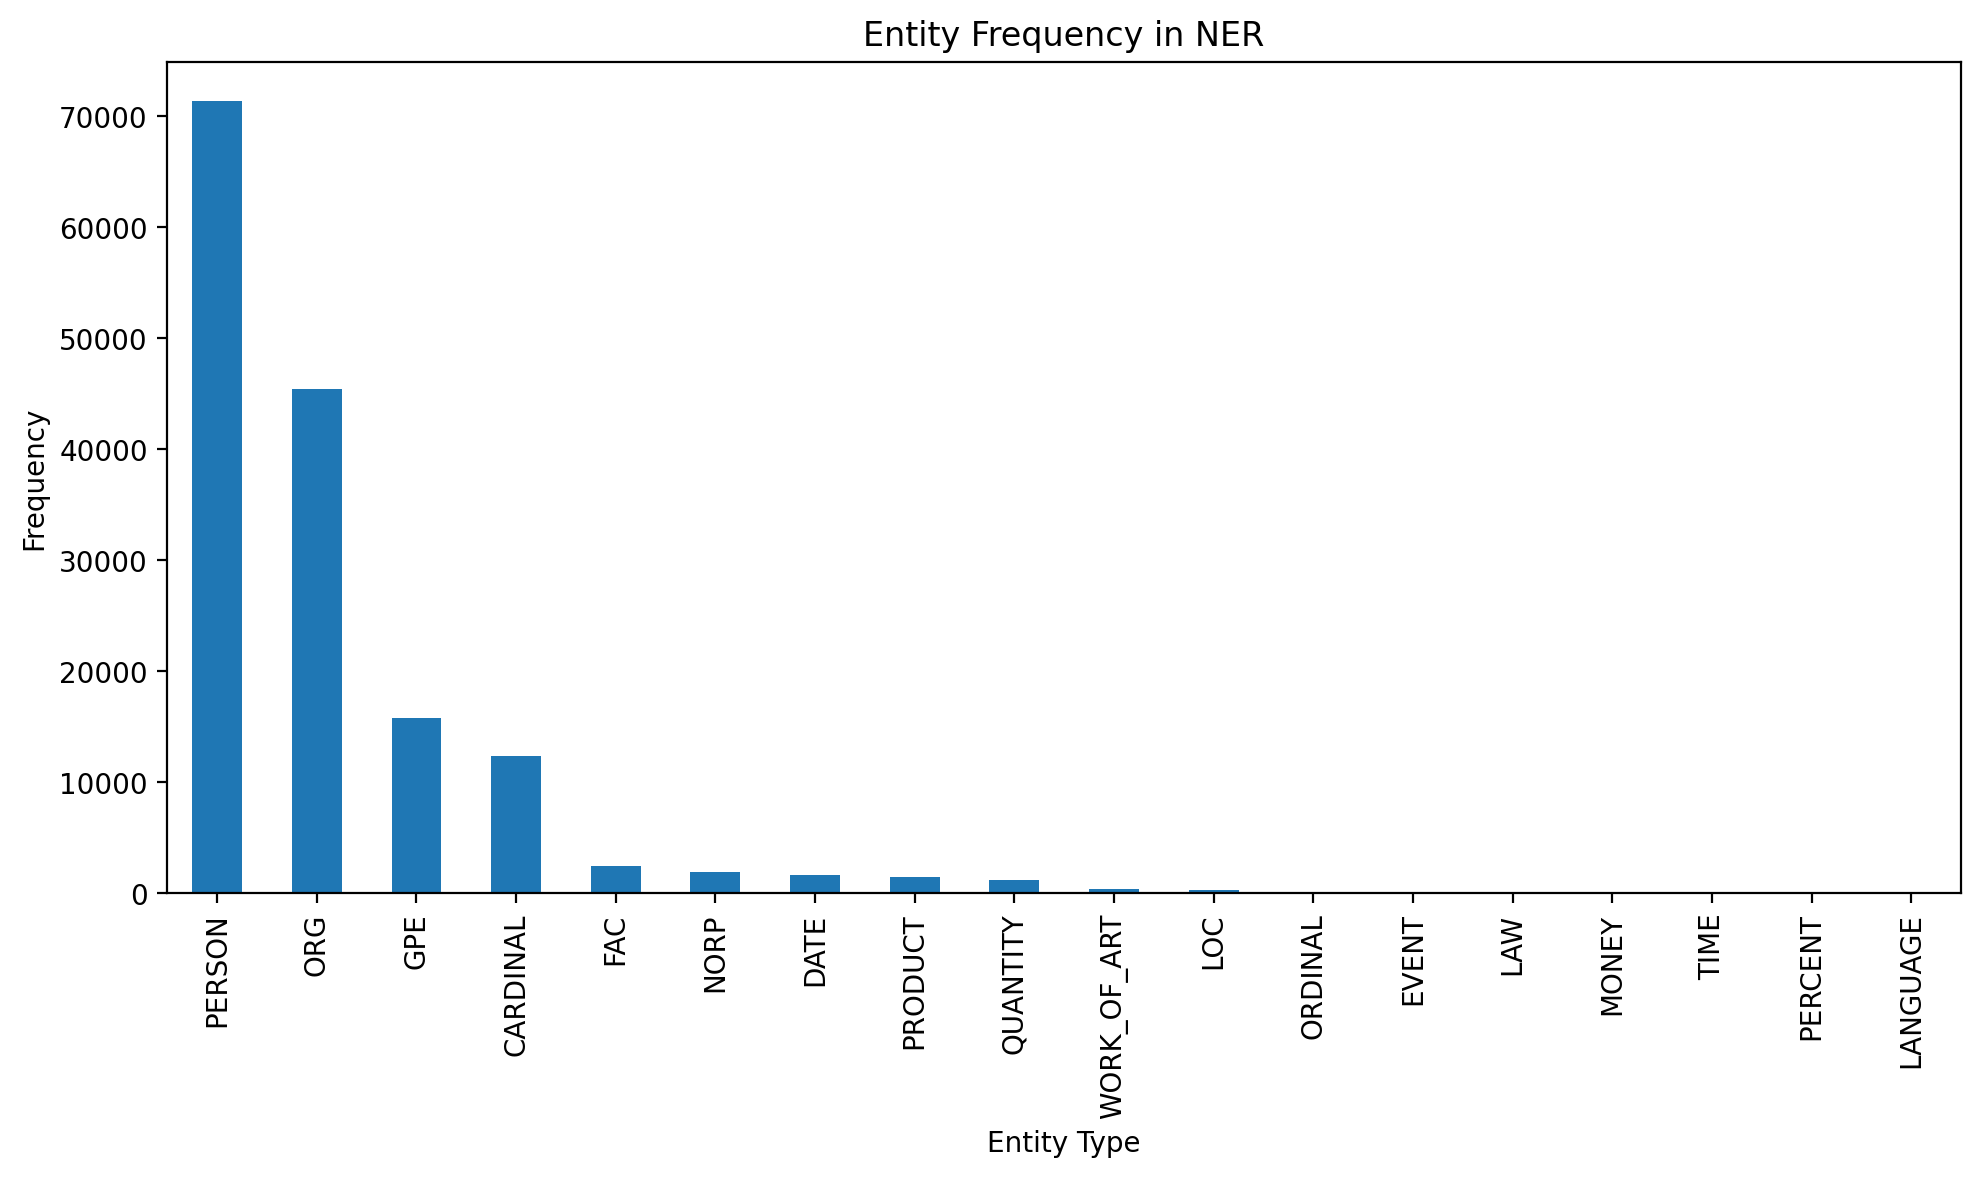

In [62]:
import spacy
import pandas as pd
from spacy import displacy
import matplotlib.pyplot as plt

# Load pre-trained spaCy model for NER (English model)
nlp = spacy.load("en_core_web_sm")  # Use "id_core_news_sm" for Bahasa Indonesia, if available

# Apply NER on review_without_stopwords
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Create a new column 'ner_entities' to store the NER results
df_satusehat_stopwords['ner_entities'] = df_satusehat_stopwords['review_without_stopwords'].apply(extract_entities)

# Example: Display the first few rows to see the NER entities
print(df_satusehat_stopwords[['review_without_stopwords', 'ner_entities']].head())

# Save the NER results into a CSV
df_satusehat_stopwords[['review_without_stopwords', 'ner_entities']].to_csv('satusehat_review_ner_results.csv', index=False)

# Visualize NER results on the first review as an example
first_review = df_satusehat_stopwords['review_without_stopwords'].iloc[0]
doc = nlp(first_review)
displacy.render(doc, style='ent', jupyter=True)

# Optionally, you can visualize named entities in a bar chart
# Count the frequency of each entity type
entity_counts = [ent.label_ for doc in df_satusehat_stopwords['review_without_stopwords'].apply(nlp)
                 for ent in doc.ents]
entity_counts_df = pd.DataFrame(entity_counts, columns=['Entity Type'])
entity_counts_plot = entity_counts_df['Entity Type'].value_counts().plot(kind='bar', figsize=(10, 6))

# Set the title and labels for the bar plot
entity_counts_plot.set_title('Entity Frequency in NER')
entity_counts_plot.set_xlabel('Entity Type')
entity_counts_plot.set_ylabel('Frequency')

# Display the bar plot
plt.tight_layout()
plt.show()
